# Modelagem preditiva
_Machine Learning_

---

## Sumário

1. **Importação de bibliotecas**
2. **Carregamento da base**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extração de amostra dos dataframes
3. **Preparação dos dados**
    - 3.1. Exibição dos metadados
    - 3.2. Análise de cardinalidade
    - 3.3. Análise de variáveis não numéricas
    - 3.4. Selecionando variáveis não aplicáveis à modelagem
    - 3.5. Segmentação das bases **train** e **test**
    - 3.6. Transformação das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos
    - 4.2. Rankeamento dos modelo por score
    - 4.3. Análise gráfica de resíduos x previsões
    - 4.4. Tunagem dos hiperparâmetros do modelo com Optuna
        - 4.4.1. Tunagem do modelo **Bayesian Ridge**
        - 4.4.2. Tunagem do modelo **Linear Regression**
        - 4.4.3. Tunagem do modelo **Huber Regressor**
        - 4.4.4. Tunagem do modelo **Lasso**
        - 4.4.5. Tunagem do modelo **ElasticNet**

<br>

---

<br>

## 1. Importação de bibliotecas

In [101]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna
import joblib
import lightgbm as lgb
import catboost as cb

from category_encoders import TargetEncoder
from sklearn.metrics import (
    make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from optuna.samplers import TPESampler

from typing import Dict, Any, List, Tuple
from sklearn.base import BaseEstimator

In [102]:
# Configurações para exibição de dados no Jupyter Notebook

# Configurar opção para exibir todas as linhas do Dataframe
pd.set_option('display.max_rows', None)

# Configurar para exibir o conteúdo completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supressão de mensagens de aviso durante a execução
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos do Seaborn
sns.set_style('whitegrid')

## 2. Carregamento da base

In [103]:
# Efetuando a limpeza da memória antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da memória: {gc.collect()}')


Quantidade de objetos removidos da memória: 14033


In [104]:
# Criando um dataframe a partir do arquivo *.csv

df = pd.read_csv('dados/Car_Purchasing_Data_Atualizado.csv', sep=';')
df.head()

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount,debt_to_annual_salary,...,age_adjusted_income,wealth_growth_rate,financial_maturity_index,email_tld,age_range,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877,0.184827,...,9692.116370,0.090581,2.717416,edu,35 to 44,0,0,0,0,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566,0.143637,...,10408.495986,0.194316,5.829491,uk,35 to 44,0,0,1,1,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921,0.207447,...,8204.202132,0.275994,8.279818,uk,35 to 44,0,0,1,1,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313,0.181758,...,10421.796563,0.119171,3.575129,com,55 to 64,1,0,1,0,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248,0.089717,...,7911.319356,0.164575,4.937235,net,55 to 64,0,0,1,0,Moderate


## 3. Preparação dos dados

### 3.1. Exibição dos metadados

In [105]:
# Função para geração de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados serão gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Variável': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata

In [106]:
generate_metadata(df)

,Variável,Tipo,Qtde de nulos,% de nulos,Cardinalidade
0,Customer Name,object,0,0.0,498
1,Customer e-mail,object,0,0.0,500
2,Country,object,0,0.0,1
3,Gender,int64,0,0.0,2
4,Age,int64,0,0.0,43
5,Annual Salary,float64,0,0.0,500
6,Credit Card Debt,float64,0,0.0,500
7,Net Worth,float64,0,0.0,500
8,Car Purchase Amount,float64,0,0.0,500
9,debt_to_annual_salary,float64,0,0.0,500


### 3.2. Análise de cardinalidade

In [107]:
# Listando todas as variáveis com cardinalidade inferior a 2

cols_low_cardinality = [col for col in df.columns if df[col].nunique(dropna=False) < 2]
print(cols_low_cardinality)


['Country']


### 3.3. Análise de variáveis não numéricas

In [108]:
# Listando todas as variáveis object e category

cols_text = df.select_dtypes(include=[object, 'category']).columns.tolist()
print(cols_text)

['Customer Name', 'Customer e-mail', 'Country', 'email_tld', 'age_range', 'financial_status_category']


In [109]:
df[cols_text].head()

,Customer Name,Customer e-mail,Country,email_tld,age_range,financial_status_category
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,edu,35 to 44,Moderate
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,uk,35 to 44,Moderate
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradipiscing.co.uk,USA,uk,35 to 44,Moderate
3,Jade Cunningham,malesuada@dignissim.com,USA,com,55 to 64,High Income - Low Debt
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,net,55 to 64,Moderate


In [110]:
# Detectar variáveis binárias (0 ou 1)
binary_cols = [
    col for col in df.columns
    if set(df[col].dropna().unique()) <= {0, 1}
]
print(binary_cols)

# Transformando variáveis binárias (0 ou 1) em categóricas
df[binary_cols] = df[binary_cols].astype('category')

['Gender', 'high_income_flag', 'high_debt_flag', 'high_net_worth_flag', 'high_ppi_flag']


In [111]:
df[binary_cols].head()

,Gender,high_income_flag,high_debt_flag,high_net_worth_flag,high_ppi_flag
0,0,0,0,0,0
1,0,0,0,1,1
2,1,0,0,1,1
3,1,1,0,1,0
4,1,0,0,1,0


### 3.4. Selecionando variáveis não aplicáveis à modelagem

In [112]:
# Separando as variáveis não aplicáveis à modelagem

vars_to_remove = ['Customer Name', 'Customer e-mail', 'Country']
if 'Age' in df.columns and 'age_range' in df.columns:
    vars_to_remove.append('Age')


### 3.5. Segmentação das bases **train** e **test**

In [113]:
# Separando as variáveis preditivas e a variável preditora (alvo)

target = 'Car Purchase Amount'
features = [col for col in df.columns if col not in [target] + vars_to_remove]


In [114]:
# Separação das features e o target
X = df[features]
y = df[target]

# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 3.6. Transformação das features das bases **train** e **test**

In [115]:
# Separando as variáveis numéricas e categóricas

numerical_features = X.select_dtypes(exclude=[object, 'category']).columns
categorical_features = X.select_dtypes(include=[object, 'category']).columns

In [116]:
# Criando o pipeline para as variáveis numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('variance', VarianceThreshold(threshold=0.0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as variáveis categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [117]:
# Criando o pipeline de pré-processamento que aplica transformações

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [118]:
# Verificando os shapes antes da transformação

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (400, 26), y_train: (400,)
Shape: X_test:  (100, 26),  y_test: (100,)


In [119]:
# Aplicando o pré-processamento nos conjuntos de treino e teste

X_train_processed = pipeline.fit_transform(X_train, y_train)
X_test_processed = pipeline.transform(X_test)

In [120]:
# Verificando os shapes após transformação

print(f'Shape de X_train após transformação: {X_train_processed.shape}')
print(f'Shape de X_test após transformação:  {X_test_processed.shape}')

Shape de X_train após transformação: (400, 43)
Shape de X_test após transformação:  (100, 43)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos

In [121]:
# Definindo os modelos a serem testados

models = {
    # Modelos lineares
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42),
    'BayesianRidge': BayesianRidge(),
    'HuberRegressor': HuberRegressor(),
    'SGDRegressor': SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    
    # Árvores e ensembles
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostRegressor(n_estimators=100, random_state=42),
    
    # Boostings modernos
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'CatBoost': cb.CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, loss_function='MAE', verbose=0),
}


In [122]:
def models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5):
    '''
    Avalia modelos de aprendizado de máquina, calculando métricas de desempenho 
    no conjunto de treino e teste.

    :param models: dict
        Dicionário contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino com as variáveis independentes.
    :param y_train: Series
        Variável dependente para o conjunto de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste com as variáveis independentes.
    :param y_test: Series
        Variável dependente para o conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada (K-Fold).

    :return: list
        Lista contendo os resultados de avaliação de cada modelo, métricas para treino 
        e teste, além do tempo de execução.
    '''
    results = []
    
    # Inicializa o esquema de validação cruzada
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }
    
    # Loop pelos modelos a serem avaliados
    for model_name, model in models.items():
        # Cria um pipeline que combina o pré-processamento e o modelo
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        
        # Registra o tempo de início
        start_time = time.time()
        
        # Executa validação cruzada no pipeline
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
        )
        
        # Calcula médias das métricas (convertendo para valores positivos)
        mean_cv_mae = -np.mean(cv_results['test_MAE'])
        mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
        mean_cv_r2 = np.mean(cv_results['test_R2'])
        
        # Ajusta o modelo final em todos os dados de treino
        pipeline.fit(X_train, y_train)
        
        # Gera previsões no conjunto de teste
        preds = pipeline.predict(X_test)
        
        # Métricas no teste
        test_rmse = np.sqrt(mean_squared_error(y_test, preds))
        test_mae = mean_absolute_error(y_test, preds)
        test_r2 = r2_score(y_test, preds)
        
        # Calcula tempo total de execução
        elapsed = time.time() - start_time
        
        # Guarda resultados
        results.append({
            'Model': model_name,
            'CV_RMSE': mean_cv_rmse,
            'Test_RMSE': test_rmse,
            'CV_MAE': mean_cv_mae,
            'Test_MAE': test_mae,
            'CV_R2': mean_cv_r2,            
            'Test_R2': test_r2,
            'Time (s)': round(elapsed, 4)
        })
        
    return results

### 4.2. Rankeamento dos modelo por score

In [123]:
def zscore_norm(series):
    '''
    Normalização Z-score: (x - média) / desvio padrão

    :param series: pd.Series
        Série numérica a ser normalizada.

    :return: pd.Series or float
        Série normalizada usando Z-score.
        Retorna 0.0 caso desvio padrão seja zero (todos iguais).
    '''
    if series.std() == 0:
        return pd.Series(0.0, index=series.index)
    
    return (series - series.mean()) / series.std()


def add_final_score(df, w_mae=0.80, w_time=0.20):
    '''
    Adiciona colunas normalizadas e calcula um ranking Final_Score
    usando Z-score utilizando pesos proporcionais.

    :param df: pd.DataFrame
        DataFrame contendo as métricas dos modelos.
    :param w_mae: float, default=0.80
        Peso atribuído à métrica MAE na composição do score final.
    :param w_time: float, default=0.20
        Peso atribuído ao tempo de execução na composição do score final.   

    :return: pd.DataFrame
        DataFrame com colunas normalizadas e ranking Final_Score.
    '''

    # Normalização robusta
    df['MAE_norm'] = zscore_norm(df['Test_MAE'])
    df['Time_norm'] = zscore_norm(df['Time (s)'])

    # Score final (menor = melhor)
    df['Final_Score'] = (
        w_mae * df['MAE_norm'] +
        w_time * df['Time_norm']
    )

    # Ordenação para ranking
    df.sort_values('Final_Score', ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [124]:
# Avaliando os modelos
results = models_evaluation(models, X_train, y_train, X_test, y_test, preprocessor)

# Criando DataFrame de resultados
df_ranked = pd.DataFrame(results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_default = add_final_score(df_ranked)

# Colunas recomendadas para análise e gráficos
df_ranked_default[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]

,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,LinearRegression,655.449819,561.578690,0.0600,-1.121265,-0.744467,-1.045905
1,BayesianRidge,646.176425,588.939077,0.0642,-1.095499,-0.735926,-1.023584
2,HuberRegressor,755.852265,738.217539,0.1313,-0.954922,-0.599465,-0.883830
3,Lasso,799.191065,777.159863,0.1180,-0.918249,-0.626513,-0.859902
4,ElasticNet,781.201419,803.274521,0.0825,-0.893657,-0.698709,-0.854667
5,Ridge,842.932178,879.050373,0.0506,-0.822298,-0.763584,-0.810555
6,SGDRegressor,1023.094973,1012.834625,0.0730,-0.696311,-0.718029,-0.700655
7,LightGBM,2182.508734,1710.724749,0.2864,-0.039100,-0.284039,-0.088087
8,GradientBoosting,2069.174945,2140.683016,0.5882,0.365798,0.329729,0.358584
9,XGBoost,2233.251279,2144.043129,0.8505,0.368962,0.863167,0.467803


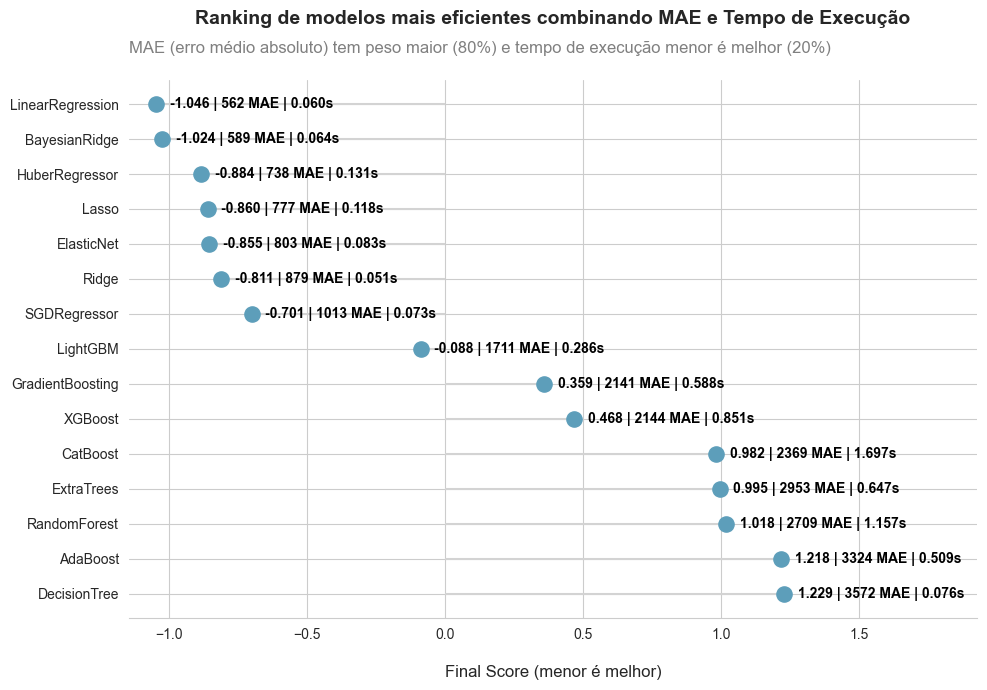

In [125]:
# Ordenar os modelos pelo Final_Score para o gráfico
df_plot = df_ranked_default.sort_values(by='Final_Score', ascending=False)

# Figura e eixo
fig, ax = plt.subplots(figsize=(10, 7))

# Linha horizontal
ax.hlines(y=df_plot['Model'], xmin=df_plot['Final_Score'], xmax=0,
    color='lightgray', linewidth=1.5)

# Pontos no valor real
ax.scatter(df_plot['Final_Score'], df_plot['Model'], 
           color='#5d9eba', s=120, zorder=3)

# Adicionar texto com MAE e tempo
for score, mae, time_s, model in zip(
    df_plot['Final_Score'], df_plot['Test_MAE'], df_plot['Time (s)'], df_plot['Model']):
    ax.text(score + 0.05, model, f'{score:.3f} | {mae:.0f} MAE | {time_s:.3f}s',
        fontweight='bold', va='center', fontsize=10, color='#000000')

# Título e labels
ax.set_title('Ranking de modelos mais eficientes combinando MAE e Tempo de Execução',
             fontsize=14, fontweight='bold', pad=40)
ax.set_xlabel('\nFinal Score (menor é melhor)', fontsize=12)
ax.set_ylabel('')

# Subtítulo explicativo
ax.text(0, 1.05, 
        'MAE (erro médio absoluto) tem peso maior (80%) e tempo de execução menor é melhor (20%)',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)

# Ajuste de eixo para não cortar textos
ax.set_xlim(df_plot['Final_Score'].min() - 0.1,
            df_plot['Final_Score'].max() + 0.7)
#ax.tick_params(labelsize=10)

# limpar borda superior e direita
sns.despine(left=True, bottom=False) 

# Ajuste final do layout para evitar sobreposição
plt.tight_layout()

# Exibição do gráfico
plt.show()


### 4.3. Análise gráfica de resíduos x previsões

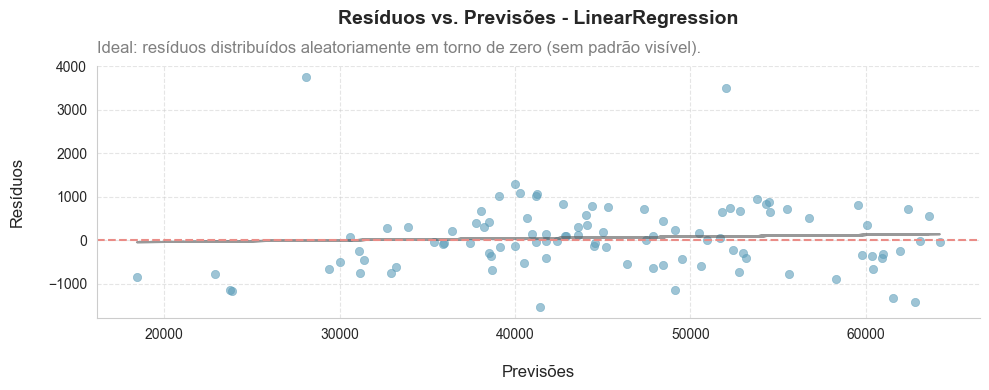

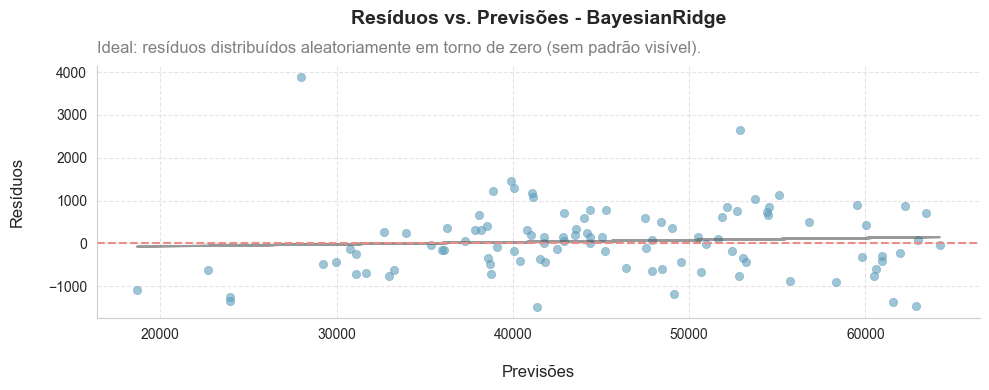

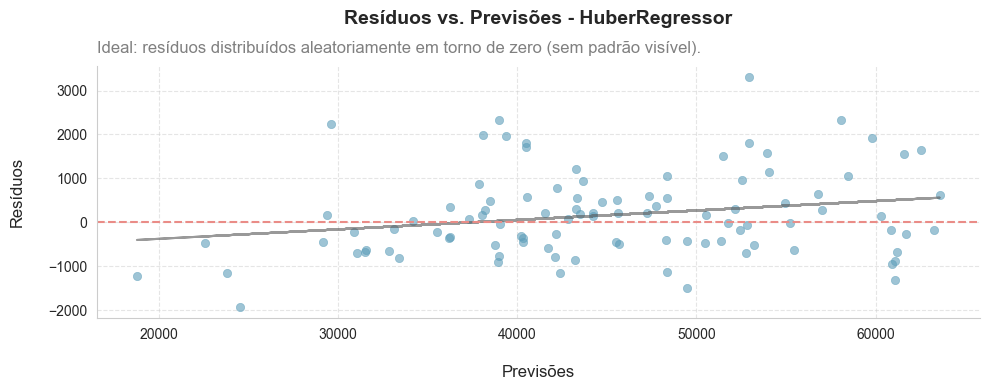

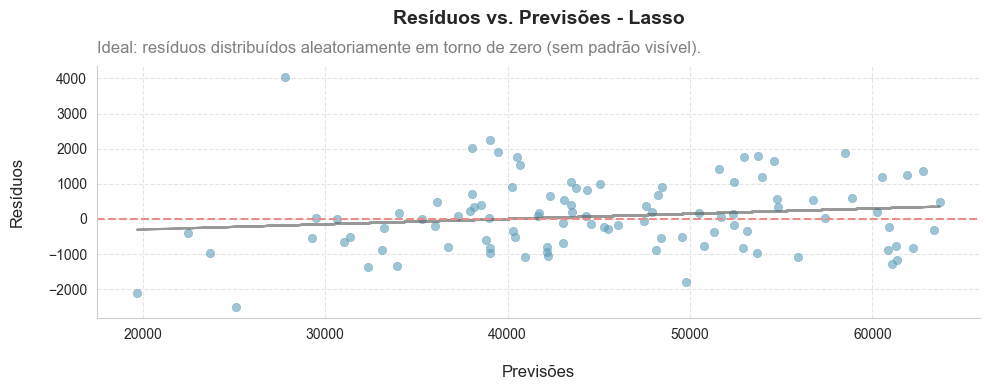

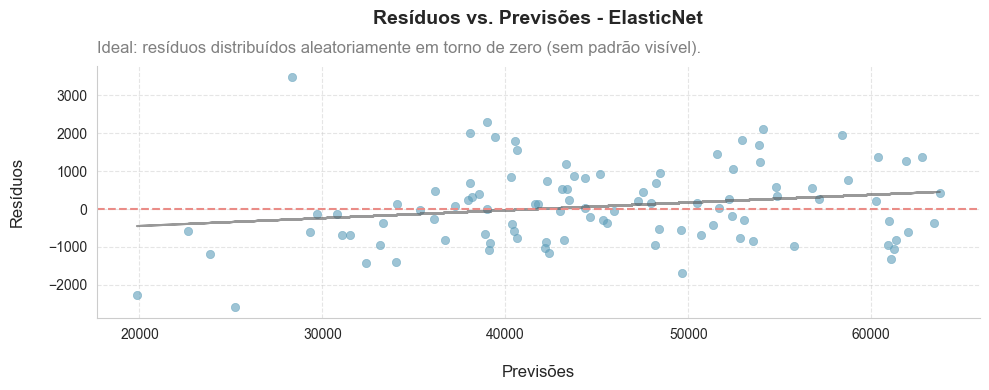

In [126]:
# Ordenar pelos menores Final_Score e pegar os 5 primeiros modelos
top_models = df_ranked.sort_values('Final_Score').head(5)['Model'].tolist()

# Loop para ajustar cada modelo e gerar o gráfico de resíduos
for model_name in top_models:
    
    # Seleção do modelo atual
    model = models[model_name]
    # Criação do pipeline com pré-processamento e modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    # Treinamento do pipeline com os dados de treino
    pipeline.fit(X_train, y_train)
    # Geração das previsões com os dados de teste
    preds = pipeline.predict(X_test)
    # Cálculo dos resíduos (diferença entre valor real e previsto)
    residuals = y_test - preds

    # Ajuste do tamanho da figura
    fig, ax = plt.subplots(figsize=(10, 4))

    # Gráfico de dispersão dos resíduos em função das previsões
    sns.scatterplot(x=preds, y=residuals, color='#5d9eba', alpha=0.6, edgecolor=None, ax=ax)

    # Linha de tendência dos resíduos
    trend_model = LinearRegression()
    trend_model.fit(preds.reshape(-1, 1), residuals)
    trend_line = trend_model.predict(preds.reshape(-1, 1))
    ax.plot(preds, trend_line, color='#555555', linestyle='-', linewidth=1.5, alpha=0.6)

    # Linha horizontal representando o ponto de resíduo zero
    ax.axhline(0, color='#ea8c87', linestyle='--', linewidth=1.5)

    # Título do gráfico com destaque
    ax.set_title(f'Resíduos vs. Previsões - {model_name}\n', fontsize=14, fontweight='bold', pad=15)  
    # Rótulo do eixo X
    ax.set_xlabel('\nPrevisões', fontsize=12)
    # Rótulo do eixo Y
    ax.set_ylabel('Resíduos\n', fontsize=12)

    # Subtítulo explicativo
    ax.text(0, 1.05, 
        'Ideal: resíduos distribuídos aleatoriamente em torno de zero (sem padrão visível).',
        fontsize=12, color='gray', ha='left', transform=ax.transAxes)
    
    # Exibição da grade para melhor leitura dos dados
    ax.grid(True, linestyle='--', alpha=0.5)
    # Ajuste dos tamanhos dos ticks
    ax.tick_params(labelsize=10)
    # Remover bordas desnecessárias
    sns.despine(right=True, top=True)

    # Ajuste final do layout para evitar sobreposição
    fig.tight_layout()
    # Exibição do gráfico
    plt.show()


### 4.4. Tunagem dos hiperparâmetros do modelo com Optuna

#### 4.4.1. Tunagem do modelo **Bayesian Ridge**

In [127]:
def objective_bayesianridge(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo BayesianRidge usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = BayesianRidge(
        max_iter=trial.suggest_int('max_iter', 100, 500),
        tol=trial.suggest_float('tol', 1e-5, 1e-2, log=True),
        alpha_1=trial.suggest_float('alpha_1', 1e-8, 1e-3, log=True),
        alpha_2=trial.suggest_float('alpha_2', 1e-8, 1e-3, log=True),
        lambda_1=trial.suggest_float('lambda_1', 1e-8, 1e-3, log=True),
        lambda_2=trial.suggest_float('lambda_2', 1e-8, 1e-3, log=True),
        fit_intercept=True,
        compute_score=False,
        copy_X=True,
        verbose=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [128]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_bayesianridge, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:26,724] A new study created in memory with name: no-name-5d4b76ca-4cd7-47ce-8080-ffcb7dbf9635
Best trial: 1. Best value: 646.176:   5%|▌         | 5/100 [00:00<00:05, 18.79it/s, 0.26/1800 seconds]

[I 2025-11-22 19:50:26,821] Trial 0 finished with value: 646.1764236861596 and parameters: {'max_iter': 497, 'tol': 0.006323635906749864, 'alpha_1': 1.879631190793319e-05, 'alpha_2': 2.444069435120595e-08, 'lambda_1': 2.606438592389103e-08, 'lambda_2': 2.0189798255472336e-08}. Best is trial 0 with value: 646.1764236861596.
[I 2025-11-22 19:50:26,859] Trial 1 finished with value: 646.1764236488485 and parameters: {'max_iter': 268, 'tol': 0.005564821231773958, 'alpha_1': 2.0153391509934344e-05, 'alpha_2': 1.6671487604471923e-07, 'lambda_1': 9.038015754992634e-08, 'lambda_2': 3.1433277493548465e-06}. Best is trial 1 with value: 646.1764236488485.
[I 2025-11-22 19:50:26,915] Trial 2 finished with value: 646.1766170875312 and parameters: {'max_iter': 205, 'tol': 1.2369674544953075e-05, 'alpha_1': 1.3671663480094387e-05, 'alpha_2': 4.70710248306663e-08, 'lambda_1': 0.0003668653890364261, 'lambda_2': 3.1024300180348856e-08}. Best is trial 1 with value: 646.1764236488485.
[I 2025-11-22 19:50:2

Best trial: 10. Best value: 646.176:  12%|█▏        | 12/100 [00:00<00:02, 30.21it/s, 0.45/1800 seconds]

[I 2025-11-22 19:50:26,986] Trial 6 finished with value: 646.1764246218589 and parameters: {'max_iter': 165, 'tol': 0.0015694661786039461, 'alpha_1': 4.9744544666629064e-08, 'alpha_2': 5.023280128182675e-07, 'lambda_1': 1.6912345071530616e-08, 'lambda_2': 1.7358569720760116e-08}. Best is trial 1 with value: 646.1764236488485.
[I 2025-11-22 19:50:27,011] Trial 7 finished with value: 646.176424636391 and parameters: {'max_iter': 362, 'tol': 0.002374178783771427, 'alpha_1': 2.609477796999665e-07, 'alpha_2': 0.00015163770161966096, 'lambda_1': 6.209225122207991e-08, 'lambda_2': 6.922328873075429e-06}. Best is trial 1 with value: 646.1764236488485.
[I 2025-11-22 19:50:27,081] Trial 8 finished with value: 646.1768728959903 and parameters: {'max_iter': 491, 'tol': 0.003604009833838382, 'alpha_1': 5.5913328772822145e-08, 'alpha_2': 0.00020582039044955767, 'lambda_1': 0.0008511709452142116, 'lambda_2': 0.00022559613385523525}. Best is trial 1 with value: 646.1764236488485.
[I 2025-11-22 19:50:2

Best trial: 15. Best value: 646.176:  16%|█▌        | 16/100 [00:00<00:03, 23.17it/s, 0.68/1800 seconds]

[I 2025-11-22 19:50:27,195] Trial 12 finished with value: 646.1764106971495 and parameters: {'max_iter': 320, 'tol': 6.7865936547728e-05, 'alpha_1': 0.00028043756201219945, 'alpha_2': 1.3049896662037705e-05, 'lambda_1': 1.5187260214609719e-06, 'lambda_2': 1.7712748831950646e-06}. Best is trial 10 with value: 646.1764004720771.
[I 2025-11-22 19:50:27,284] Trial 13 finished with value: 646.1763926526887 and parameters: {'max_iter': 148, 'tol': 0.008096345658985952, 'alpha_1': 0.0006107938004270581, 'alpha_2': 1.1509192317982796e-08, 'lambda_1': 3.0700417868807723e-08, 'lambda_2': 5.092762397345477e-07}. Best is trial 13 with value: 646.1763926526887.
[I 2025-11-22 19:50:27,346] Trial 14 finished with value: 646.176466406923 and parameters: {'max_iter': 221, 'tol': 2.0493845296102288e-05, 'alpha_1': 2.342475077670731e-06, 'alpha_2': 6.278602875813225e-05, 'lambda_1': 7.96142017874937e-05, 'lambda_2': 7.6097750257851605e-06}. Best is trial 13 with value: 646.1763926526887.
[I 2025-11-22 19

Best trial: 16. Best value: 646.176:  23%|██▎       | 23/100 [00:00<00:03, 25.45it/s, 0.91/1800 seconds]

[I 2025-11-22 19:50:27,463] Trial 16 finished with value: 646.1763822737315 and parameters: {'max_iter': 390, 'tol': 0.0005207891818312955, 'alpha_1': 0.0008153366778320996, 'alpha_2': 1.0254736232083226e-08, 'lambda_1': 8.039850452736637e-07, 'lambda_2': 0.00046712220530409983}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19:50:27,498] Trial 18 finished with value: 646.1763888960794 and parameters: {'max_iter': 398, 'tol': 0.000666549370328607, 'alpha_1': 0.000981687259801645, 'alpha_2': 1.5806348593354922e-08, 'lambda_1': 2.9940741981094564e-05, 'lambda_2': 0.0003675605808031472}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19:50:27,498] Trial 17 finished with value: 646.1763865261961 and parameters: {'max_iter': 392, 'tol': 0.0005959677580416962, 'alpha_1': 0.0007342426337418079, 'alpha_2': 4.4934051979554277e-07, 'lambda_1': 7.902260616324627e-07, 'lambda_2': 0.00046113988948955585}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 1

Best trial: 16. Best value: 646.176:  29%|██▉       | 29/100 [00:01<00:02, 25.12it/s, 1.14/1800 seconds]

[I 2025-11-22 19:50:27,673] Trial 23 finished with value: 646.1764215319045 and parameters: {'max_iter': 445, 'tol': 0.00028460068416332634, 'alpha_1': 6.390997140381543e-05, 'alpha_2': 7.90220719720891e-08, 'lambda_1': 5.271111770470768e-07, 'lambda_2': 6.970135853893955e-05}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19:50:27,777] Trial 24 finished with value: 646.1764151004609 and parameters: {'max_iter': 445, 'tol': 0.000314736718835844, 'alpha_1': 0.00018598793998139747, 'alpha_2': 9.900321404644152e-08, 'lambda_1': 4.7126893428913185e-07, 'lambda_2': 0.00011782525360769319}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19:50:27,783] Trial 27 finished with value: 646.1764248878727 and parameters: {'max_iter': 446, 'tol': 0.0003699835253564682, 'alpha_1': 1.3740344997773286e-08, 'alpha_2': 7.922137913813361e-08, 'lambda_1': 5.38165207832611e-07, 'lambda_2': 0.00014251148482699008}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19

Best trial: 31. Best value: 646.176:  34%|███▍      | 34/100 [00:01<00:02, 26.47it/s, 1.35/1800 seconds]

[I 2025-11-22 19:50:27,890] Trial 29 finished with value: 646.1763854172011 and parameters: {'max_iter': 349, 'tol': 0.000336789596817759, 'alpha_1': 0.0008101105427394575, 'alpha_2': 2.878775468634052e-08, 'lambda_1': 6.252283893735072e-06, 'lambda_2': 0.0001778654341277387}. Best is trial 16 with value: 646.1763822737315.
[I 2025-11-22 19:50:27,969] Trial 30 finished with value: 646.1763762001254 and parameters: {'max_iter': 344, 'tol': 0.001488154501302735, 'alpha_1': 0.0009880604019219452, 'alpha_2': 2.7905668908621767e-08, 'lambda_1': 6.45225985186589e-06, 'lambda_2': 0.0008390133539318148}. Best is trial 30 with value: 646.1763762001254.
[I 2025-11-22 19:50:27,976] Trial 31 finished with value: 646.176375466425 and parameters: {'max_iter': 355, 'tol': 0.001418994878365378, 'alpha_1': 0.000991319057670746, 'alpha_2': 2.7328205895594806e-08, 'lambda_1': 5.3846894394268536e-06, 'lambda_2': 0.0009577485878826275}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:50:28,

Best trial: 31. Best value: 646.176:  40%|████      | 40/100 [00:01<00:02, 24.95it/s, 1.58/1800 seconds]

[I 2025-11-22 19:50:28,112] Trial 35 finished with value: 646.1764256320924 and parameters: {'max_iter': 350, 'tol': 0.0014608120801713044, 'alpha_1': 3.0560148899560805e-05, 'alpha_2': 3.3390327290784146e-08, 'lambda_1': 4.971768873271175e-06, 'lambda_2': 1.5760785270522376e-05}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:50:28,162] Trial 36 finished with value: 646.1764254775577 and parameters: {'max_iter': 273, 'tol': 0.0013525093561281547, 'alpha_1': 3.656303163538561e-05, 'alpha_2': 2.8212079108143496e-08, 'lambda_1': 5.283996055264337e-06, 'lambda_2': 0.000985748363269606}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:50:28,162] Trial 37 finished with value: 646.1764254162983 and parameters: {'max_iter': 273, 'tol': 0.0013723497440594793, 'alpha_1': 3.1201969006587225e-05, 'alpha_2': 2.5031005862742996e-08, 'lambda_1': 4.631623887849479e-06, 'lambda_2': 0.0006118488351326168}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:

Best trial: 44. Best value: 646.176:  45%|████▌     | 45/100 [00:01<00:02, 26.85it/s, 1.79/1800 seconds]

[I 2025-11-22 19:50:28,311] Trial 41 finished with value: 646.1764254453767 and parameters: {'max_iter': 327, 'tol': 0.0001775265124353772, 'alpha_1': 0.0004772749894119227, 'alpha_2': 2.2243252408139667e-07, 'lambda_1': 4.9122980493520354e-05, 'lambda_2': 0.0002980987036238916}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:50:28,395] Trial 43 finished with value: 646.1764403132618 and parameters: {'max_iter': 323, 'tol': 0.00020951092054459036, 'alpha_1': 0.00038511991659952746, 'alpha_2': 2.2956916292982945e-07, 'lambda_1': 6.817872393457305e-05, 'lambda_2': 0.00030201603359606235}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 19:50:28,397] Trial 42 finished with value: 646.1764355485426 and parameters: {'max_iter': 322, 'tol': 0.00021976241483142334, 'alpha_1': 0.0003974276805367358, 'alpha_2': 2.481416750695443e-07, 'lambda_1': 6.0356764499545635e-05, 'lambda_2': 0.000294853738231625}. Best is trial 31 with value: 646.176375466425.
[I 2025-11-22 1

[I 2025-11-22 19:50:28,539] Trial 45 finished with value: 646.1763758773543 and parameters: {'max_iter': 376, 'tol': 0.0021371376460138777, 'alpha_1': 0.000948922797487516, 'alpha_2': 5.7260828335834194e-08, 'lambda_1': 1.9367220772737407e-06, 'lambda_2': 7.818960783491884e-05}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 19:50:28,619] Trial 47 finished with value: 646.1763779761079 and parameters: {'max_iter': 371, 'tol': 0.00044755764205311387, 'alpha_1': 0.0009088272442220773, 'alpha_2': 5.4363278713901025e-08, 'lambda_1': 1.9513003541480026e-06, 'lambda_2': 6.824196589237525e-05}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 19:50:28,620] Trial 48 finished with value: 646.1763762834419 and parameters: {'max_iter': 371, 'tol': 0.0037242351589168495, 'alpha_1': 0.0009428791136753558, 'alpha_2': 5.290259781470365e-08, 'lambda_1': 2.0449236234965823e-06, 'lambda_2': 6.916074066797902e-05}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 

Best trial: 44. Best value: 646.176:  55%|█████▌    | 55/100 [00:02<00:01, 22.81it/s, 2.23/1800 seconds]

[I 2025-11-22 19:50:28,756] Trial 50 finished with value: 646.1764250067223 and parameters: {'max_iter': 372, 'tol': 0.0022278304136286657, 'alpha_1': 1.2562313206234448e-05, 'alpha_2': 5.273068071029107e-08, 'lambda_1': 1.990266678556346e-06, 'lambda_2': 6.860749598983972e-05}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 19:50:28,848] Trial 51 finished with value: 646.1764184929546 and parameters: {'max_iter': 295, 'tol': 0.004216780901988562, 'alpha_1': 0.0001199897428696418, 'alpha_2': 2.12243926718753e-06, 'lambda_1': 2.410447978432956e-07, 'lambda_2': 5.888146348761215e-06}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 19:50:28,898] Trial 52 finished with value: 646.1764174519377 and parameters: {'max_iter': 235, 'tol': 0.004207804354377044, 'alpha_1': 0.0001393702926868583, 'alpha_2': 1.712088202228582e-08, 'lambda_1': 1.9429268168394804e-07, 'lambda_2': 8.917092275560188e-06}. Best is trial 44 with value: 646.1763738784141.
[I 2025-11-22 19:50:

Best trial: 56. Best value: 646.176:  60%|██████    | 60/100 [00:02<00:01, 24.50it/s, 2.46/1800 seconds]

[I 2025-11-22 19:50:28,987] Trial 56 finished with value: 646.1763726900951 and parameters: {'max_iter': 425, 'tol': 0.0038013564965322637, 'alpha_1': 0.000993258378564687, 'alpha_2': 1.5823707420485918e-08, 'lambda_1': 2.3784292326419392e-07, 'lambda_2': 1.0733130919185573e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,057] Trial 55 finished with value: 646.1764247489949 and parameters: {'max_iter': 302, 'tol': 0.0034058725457250445, 'alpha_1': 3.007206469673029e-07, 'alpha_2': 1.6924262717118327e-08, 'lambda_1': 2.1885911395613886e-07, 'lambda_2': 1.086718424048044e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,057] Trial 57 finished with value: 646.1763768804843 and parameters: {'max_iter': 333, 'tol': 0.0051341966733458, 'alpha_1': 0.0009243952759086358, 'alpha_2': 1.6447255283330268e-08, 'lambda_1': 1.3203284295840112e-06, 'lambda_2': 1.0639508460075362e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 1

Best trial: 56. Best value: 646.176:  66%|██████▌   | 66/100 [00:02<00:01, 26.07it/s, 2.67/1800 seconds]

[I 2025-11-22 19:50:29,214] Trial 60 finished with value: 646.1763759620283 and parameters: {'max_iter': 422, 'tol': 0.008342087687537292, 'alpha_1': 0.0009409803962507685, 'alpha_2': 1.2612211369928047e-07, 'lambda_1': 1.2144525929482559e-06, 'lambda_2': 2.6511431135381682e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,215] Trial 61 finished with value: 646.1764246753825 and parameters: {'max_iter': 424, 'tol': 0.009247790988062736, 'alpha_1': 3.5384005085388054e-07, 'alpha_2': 1.852289318235706e-08, 'lambda_1': 7.158822251404578e-08, 'lambda_2': 1.7309049679706553e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,239] Trial 62 finished with value: 646.1763959957868 and parameters: {'max_iter': 430, 'tol': 0.007667911516106673, 'alpha_1': 0.0005474062873066625, 'alpha_2': 1.3923973581733453e-05, 'lambda_1': 6.714150880273254e-08, 'lambda_2': 2.5750167641859654e-06}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 1

Best trial: 56. Best value: 646.176:  72%|███████▏  | 72/100 [00:02<00:01, 25.73it/s, 2.87/1800 seconds]

[I 2025-11-22 19:50:29,426] Trial 66 finished with value: 646.17641267529 and parameters: {'max_iter': 478, 'tol': 0.0028324759996598246, 'alpha_1': 0.0003196502424937788, 'alpha_2': 7.139019407792685e-08, 'lambda_1': 9.154763137792685e-06, 'lambda_2': 3.744553726946771e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,426] Trial 67 finished with value: 646.1764185677632 and parameters: {'max_iter': 483, 'tol': 0.002877700459419913, 'alpha_1': 0.00021999383485875798, 'alpha_2': 7.34654982413976e-08, 'lambda_1': 1.0420253021000517e-05, 'lambda_2': 3.3872442714726726e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,493] Trial 68 finished with value: 646.1764114552498 and parameters: {'max_iter': 467, 'tol': 0.0009927598820503494, 'alpha_1': 0.0002523039229389369, 'alpha_2': 4.154136323037865e-07, 'lambda_1': 1.309790120852362e-07, 'lambda_2': 3.373542874922945e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:

Best trial: 56. Best value: 646.176:  77%|███████▋  | 77/100 [00:03<00:01, 22.52it/s, 3.13/1800 seconds]

[I 2025-11-22 19:50:29,658] Trial 73 finished with value: 646.1763920950345 and parameters: {'max_iter': 466, 'tol': 0.0017678155544564493, 'alpha_1': 0.0006542274837940818, 'alpha_2': 4.1358893415434024e-07, 'lambda_1': 3.391485808812727e-06, 'lambda_2': 9.865265137948136e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,713] Trial 74 finished with value: 646.1764262973427 and parameters: {'max_iter': 386, 'tol': 0.001794314465837911, 'alpha_1': 2.4400519220642335e-06, 'alpha_2': 3.701792352775496e-08, 'lambda_1': 3.4352523150168414e-06, 'lambda_2': 5.6079330557269304e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,827] Trial 76 finished with value: 646.1763744180382 and parameters: {'max_iter': 384, 'tol': 0.0019002022749617029, 'alpha_1': 0.0009877346381868296, 'alpha_2': 4.3178770875391424e-08, 'lambda_1': 3.030286082103664e-06, 'lambda_2': 0.00011379466299058374}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 

Best trial: 56. Best value: 646.176:  83%|████████▎ | 83/100 [00:03<00:00, 25.03it/s, 3.36/1800 seconds]

[I 2025-11-22 19:50:29,912] Trial 77 finished with value: 646.1763891627477 and parameters: {'max_iter': 387, 'tol': 0.0018958643017674462, 'alpha_1': 0.0006851227848028651, 'alpha_2': 3.87381114451102e-08, 'lambda_1': 8.960061539676332e-07, 'lambda_2': 8.107321931385542e-07}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,916] Trial 78 finished with value: 646.1763728141416 and parameters: {'max_iter': 362, 'tol': 0.005561776148325662, 'alpha_1': 0.0009889501281157838, 'alpha_2': 4.138451339645766e-08, 'lambda_1': 2.8166652797183726e-08, 'lambda_2': 5.6899928103144886e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:29,976] Trial 80 finished with value: 646.1763877149081 and parameters: {'max_iter': 363, 'tol': 0.0064247576682000505, 'alpha_1': 0.0007143816773477769, 'alpha_2': 3.965204741958726e-08, 'lambda_1': 9.919736164327332e-07, 'lambda_2': 0.0005371457052522536}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50

Best trial: 56. Best value: 646.176:  88%|████████▊ | 88/100 [00:03<00:00, 23.38it/s, 3.58/1800 seconds]

[I 2025-11-22 19:50:30,125] Trial 82 finished with value: 646.176388897792 and parameters: {'max_iter': 406, 'tol': 0.005852139448770518, 'alpha_1': 0.0006921652191227813, 'alpha_2': 1.1835128184883211e-07, 'lambda_1': 1.0168864359361632e-06, 'lambda_2': 2.350491740331936e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,195] Trial 84 finished with value: 646.1764001426005 and parameters: {'max_iter': 398, 'tol': 0.005733834249155535, 'alpha_1': 0.00046783970032355534, 'alpha_2': 1.1188925478185455e-07, 'lambda_1': 3.3951594561025114e-08, 'lambda_2': 2.2792232599590513e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,208] Trial 85 finished with value: 646.1763993791477 and parameters: {'max_iter': 401, 'tol': 0.0050217041320331475, 'alpha_1': 0.0004823717551232073, 'alpha_2': 1.2985766092724908e-08, 'lambda_1': 3.261419371035711e-08, 'lambda_2': 5.013940431599214e-05}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 1

[I 2025-11-22 19:50:30,333] Trial 89 finished with value: 646.1764013888298 and parameters: {'max_iter': 454, 'tol': 0.004548143398475993, 'alpha_1': 0.00044398806117928997, 'alpha_2': 2.3373480311096793e-08, 'lambda_1': 2.4250640718514505e-08, 'lambda_2': 2.8234784864893115e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,454] Trial 90 finished with value: 646.1764069865005 and parameters: {'max_iter': 441, 'tol': 0.0035975957848037227, 'alpha_1': 0.00034083967331969883, 'alpha_2': 3.7771134344078015e-06, 'lambda_1': 3.982466524016965e-07, 'lambda_2': 7.9227760625811e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,492] Trial 92 finished with value: 646.1763729211789 and parameters: {'max_iter': 441, 'tol': 0.0036677143757246756, 'alpha_1': 0.0009931530012597264, 'alpha_2': 2.3063784032060238e-08, 'lambda_1': 6.651947863027245e-07, 'lambda_2': 4.4732114335480405e-08}. Best is trial 56 with value: 646.1763726900951.


Best trial: 56. Best value: 646.176:  98%|█████████▊| 98/100 [00:03<00:00, 21.03it/s, 3.99/1800 seconds]

[I 2025-11-22 19:50:30,548] Trial 91 finished with value: 646.1764155762296 and parameters: {'max_iter': 438, 'tol': 0.0038490468030375324, 'alpha_1': 0.0001732294833987432, 'alpha_2': 2.290303988894889e-08, 'lambda_1': 1.996248791172714e-08, 'lambda_2': 1.146621988733571e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,591] Trial 93 finished with value: 646.1764159817835 and parameters: {'max_iter': 440, 'tol': 0.003678699268376186, 'alpha_1': 0.00016869652977610246, 'alpha_2': 4.7167557238495545e-06, 'lambda_1': 3.382840085947717e-07, 'lambda_2': 1.3129186039239984e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,670] Trial 94 finished with value: 646.176424855104 and parameters: {'max_iter': 362, 'tol': 0.003373024023514246, 'alpha_1': 1.1032635664610274e-07, 'alpha_2': 5.98964268205196e-07, 'lambda_1': 4.0091649985201125e-07, 'lambda_2': 5.133988210271036e-06}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:5

Best trial: 56. Best value: 646.176: 100%|██████████| 100/100 [00:04<00:00, 24.72it/s, 4.05/1800 seconds]

[I 2025-11-22 19:50:30,737] Trial 97 finished with value: 646.1764160525878 and parameters: {'max_iter': 386, 'tol': 0.007158440994960112, 'alpha_1': 0.00017078423651235633, 'alpha_2': 2.2412723578497895e-08, 'lambda_1': 6.639430782103587e-07, 'lambda_2': 8.090808747299974e-08}. Best is trial 56 with value: 646.1763726900951.
[I 2025-11-22 19:50:30,768] Trial 99 finished with value: 646.1763740327954 and parameters: {'max_iter': 362, 'tol': 0.007308674509167574, 'alpha_1': 0.0009719291062175519, 'alpha_2': 5.749775688615115e-08, 'lambda_1': 6.464726018193978e-07, 'lambda_2': 1.4921688056579346e-07}. Best is trial 56 with value: 646.1763726900951.


In [129]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_bayesianridge = study.best_value
params_bayesianridge = study.best_params

print(f'Melhores hiperparâmetros: {params_bayesianridge}')
print(f'\nMelhor MAE: {mae_bayesianridge:.4f}')

Melhores hiperparâmetros: {'max_iter': 425, 'tol': 0.0038013564965322637, 'alpha_1': 0.000993258378564687, 'alpha_2': 1.5823707420485918e-08, 'lambda_1': 2.3784292326419392e-07, 'lambda_2': 1.0733130919185573e-05}

Melhor MAE: 646.1764


#### 4.4.2. Tunagem do modelo **Linear Regression**

In [130]:
def objective_linearregression(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo LinearRegression usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = LinearRegression(
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        positive=trial.suggest_categorical('positive', [True, False]),
        n_jobs=None
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()

In [131]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_linearregression, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:30,804] A new study created in memory with name: no-name-71dab04c-d350-461b-9a18-81317ef1d07b
Best trial: 4. Best value: 655.45:   4%|▍         | 4/100 [00:00<00:13,  7.24it/s, 0.31/1800 seconds] 

[I 2025-11-22 19:50:30,959] Trial 1 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 1 with value: 1898.543364004717.
[I 2025-11-22 19:50:31,076] Trial 3 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 3 with value: 655.4498191947844.
[I 2025-11-22 19:50:31,101] Trial 4 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,102] Trial 2 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,114] Trial 0 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.


Best trial: 4. Best value: 655.45:  12%|█▏        | 12/100 [00:00<00:02, 31.04it/s, 0.50/1800 seconds]

[I 2025-11-22 19:50:31,129] Trial 5 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,151] Trial 6 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,181] Trial 7 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,210] Trial 8 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,233] Trial 9 finished with value: 1898.543364004717 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,285] Trial 10 finished with value: 655.4498191947774 and parameters:

Best trial: 4. Best value: 655.45:  19%|█▉        | 19/100 [00:00<00:02, 32.01it/s, 0.72/1800 seconds]

[I 2025-11-22 19:50:31,361] Trial 13 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,418] Trial 14 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,418] Trial 15 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,466] Trial 16 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,497] Trial 17 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,510] Trial 18 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  27%|██▋       | 27/100 [00:00<00:02, 32.39it/s, 0.93/1800 seconds]

[I 2025-11-22 19:50:31,567] Trial 19 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,569] Trial 20 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,619] Trial 21 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,619] Trial 22 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,673] Trial 23 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,674] Trial 24 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  34%|███▍      | 34/100 [00:01<00:01, 35.25it/s, 1.13/1800 seconds]

[I 2025-11-22 19:50:31,770] Trial 27 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,779] Trial 28 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,824] Trial 30 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,834] Trial 29 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,869] Trial 31 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:31,894] Trial 32 finished with value: 1898.5433640047165 and

Best trial: 4. Best value: 655.45:  39%|███▉      | 39/100 [00:01<00:01, 34.76it/s, 1.34/1800 seconds]

[I 2025-11-22 19:50:31,960] Trial 34 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,018] Trial 35 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,028] Trial 36 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,085] Trial 37 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,134] Trial 38 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.


Best trial: 4. Best value: 655.45:  44%|████▍     | 44/100 [00:01<00:01, 29.21it/s, 1.50/1800 seconds]

[I 2025-11-22 19:50:32,168] Trial 39 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,215] Trial 40 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,250] Trial 41 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,260] Trial 42 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,308] Trial 43 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.


Best trial: 4. Best value: 655.45:  50%|█████     | 50/100 [00:01<00:01, 30.14it/s, 1.70/1800 seconds]

[I 2025-11-22 19:50:32,356] Trial 44 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,364] Trial 45 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,415] Trial 46 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,446] Trial 48 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,469] Trial 47 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,493] Trial 49 finished with value: 655.4498191947774 and par

Best trial: 4. Best value: 655.45:  58%|█████▊    | 58/100 [00:01<00:01, 32.45it/s, 1.91/1800 seconds]

[I 2025-11-22 19:50:32,548] Trial 51 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,558] Trial 50 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,596] Trial 52 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,596] Trial 53 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,647] Trial 54 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,657] Trial 55 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  66%|██████▌   | 66/100 [00:02<00:00, 35.67it/s, 2.12/1800 seconds]

[I 2025-11-22 19:50:32,727] Trial 58 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,770] Trial 59 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,778] Trial 60 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,805] Trial 61 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,829] Trial 62 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:32,856] Trial 63 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  71%|███████   | 71/100 [00:02<00:00, 33.80it/s, 2.29/1800 seconds]

[I 2025-11-22 19:50:32,925] Trial 66 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,009] Trial 67 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,054] Trial 68 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,080] Trial 69 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,088] Trial 70 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.


Best trial: 4. Best value: 655.45:  78%|███████▊  | 78/100 [00:02<00:00, 34.30it/s, 2.49/1800 seconds]

[I 2025-11-22 19:50:33,133] Trial 71 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,143] Trial 72 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,181] Trial 73 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,204] Trial 74 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,240] Trial 75 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,252] Trial 76 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45:  87%|████████▋ | 87/100 [00:02<00:00, 36.34it/s, 2.73/1800 seconds]

[I 2025-11-22 19:50:33,343] Trial 79 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,354] Trial 80 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,380] Trial 81 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,405] Trial 82 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,441] Trial 83 finished with value: 1898.5433640047165 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,454] Trial 84 finished with value: 1898.5433640047165 and

Best trial: 4. Best value: 655.45:  94%|█████████▍| 94/100 [00:02<00:00, 37.24it/s, 2.91/1800 seconds]

[I 2025-11-22 19:50:33,543] Trial 87 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,564] Trial 88 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,601] Trial 89 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,630] Trial 90 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,638] Trial 91 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,676] Trial 92 finished with value: 655.4498191947774 and 

Best trial: 4. Best value: 655.45: 100%|██████████| 100/100 [00:03<00:00, 32.89it/s, 3.04/1800 seconds]

[I 2025-11-22 19:50:33,720] Trial 94 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,744] Trial 95 finished with value: 655.4498191947774 and parameters: {'fit_intercept': False, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,764] Trial 96 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,795] Trial 97 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,829] Trial 98 finished with value: 655.4498191947844 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 4 with value: 655.4498191947774.
[I 2025-11-22 19:50:33,842] Trial 99 finished with value: 655.4498191947774 and para

In [132]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_linearregression = study.best_value
params_linearregression = study.best_params

print(f'Melhores hiperparâmetros: {params_linearregression}')
print(f'\nMelhor MAE: {mae_linearregression:.4f}')

Melhores hiperparâmetros: {'fit_intercept': False, 'positive': False}

Melhor MAE: 655.4498


#### 4.4.3. Tunagem do modelo **Huber Regressor**

In [133]:
def objective_huberregressor(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo HuberRegressor usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = HuberRegressor(
        epsilon=trial.suggest_float('epsilon', 1.1, 2.0),
        alpha=trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        max_iter=trial.suggest_int('max_iter', 100, 1000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        fit_intercept=trial.suggest_categorical('fit_intercept', [True, False]),
        warm_start=False
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [134]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_huberregressor, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:33,880] A new study created in memory with name: no-name-90f3731c-073c-4667-840c-6dfad7d0c77d
Best trial: 0. Best value: 867.049:   1%|          | 1/100 [00:00<00:29,  3.31it/s, 0.30/1800 seconds]

[I 2025-11-22 19:50:34,174] Trial 0 finished with value: 867.0491630850078 and parameters: {'epsilon': 1.4635342129852205, 'alpha': 0.0015242495378885463, 'max_iter': 723, 'tol': 5.457460410485231e-05, 'fit_intercept': True}. Best is trial 0 with value: 867.0491630850078.


Best trial: 0. Best value: 867.049:   5%|▌         | 5/100 [00:00<00:13,  7.08it/s, 0.72/1800 seconds]

[I 2025-11-22 19:50:34,418] Trial 1 finished with value: 1048.57170733972 and parameters: {'epsilon': 1.9134598065529815, 'alpha': 0.0030188878091315908, 'max_iter': 489, 'tol': 1.2208708630732004e-05, 'fit_intercept': False}. Best is trial 0 with value: 867.0491630850078.
[I 2025-11-22 19:50:34,523] Trial 2 finished with value: 1017.6109426474508 and parameters: {'epsilon': 1.5295297324795634, 'alpha': 0.0065358372958845825, 'max_iter': 309, 'tol': 4.4492038297615344e-05, 'fit_intercept': True}. Best is trial 0 with value: 867.0491630850078.
[I 2025-11-22 19:50:34,560] Trial 4 finished with value: 1405.346749395481 and parameters: {'epsilon': 1.169120666816676, 'alpha': 0.007734332847726112, 'max_iter': 860, 'tol': 0.0008014025542880567, 'fit_intercept': False}. Best is trial 0 with value: 867.0491630850078.
[I 2025-11-22 19:50:34,597] Trial 3 finished with value: 1098.6225980821741 and parameters: {'epsilon': 1.470065648098043, 'alpha': 0.004086071150735962, 'max_iter': 872, 'tol': 1

Best trial: 0. Best value: 867.049:   8%|▊         | 8/100 [00:00<00:08, 10.34it/s, 0.98/1800 seconds]

[I 2025-11-22 19:50:34,694] Trial 5 finished with value: 3126.636073031213 and parameters: {'epsilon': 1.3807781994225437, 'alpha': 0.01683620183632245, 'max_iter': 424, 'tol': 2.917844446806354e-05, 'fit_intercept': False}. Best is trial 0 with value: 867.0491630850078.
[I 2025-11-22 19:50:34,760] Trial 6 finished with value: 1394.4749682449087 and parameters: {'epsilon': 1.8922269766964168, 'alpha': 0.01831422462248592, 'max_iter': 206, 'tol': 0.0003088043982612276, 'fit_intercept': True}. Best is trial 0 with value: 867.0491630850078.
[I 2025-11-22 19:50:34,859] Trial 7 finished with value: 1042.8332811527118 and parameters: {'epsilon': 1.767782521669523, 'alpha': 0.0029041230517308316, 'max_iter': 112, 'tol': 1.1408193773286772e-06, 'fit_intercept': False}. Best is trial 0 with value: 867.0491630850078.


Best trial: 0. Best value: 867.049:   9%|▉         | 9/100 [00:01<00:08, 10.34it/s, 1.02/1800 seconds]

[I 2025-11-22 19:50:34,902] Trial 8 finished with value: 926.0335929613464 and parameters: {'epsilon': 1.7972105196701973, 'alpha': 0.0010036338577120235, 'max_iter': 880, 'tol': 5.4292747385542534e-05, 'fit_intercept': False}. Best is trial 0 with value: 867.0491630850078.


Best trial: 9. Best value: 731.181:  11%|█         | 11/100 [00:01<00:10,  8.76it/s, 1.38/1800 seconds]

[I 2025-11-22 19:50:35,155] Trial 9 finished with value: 731.1805160387565 and parameters: {'epsilon': 1.9093130268589853, 'alpha': 0.00015427217524595114, 'max_iter': 845, 'tol': 0.00011805075431846602, 'fit_intercept': True}. Best is trial 9 with value: 731.1805160387565.
[I 2025-11-22 19:50:35,265] Trial 11 finished with value: 6501.080045884249 and parameters: {'epsilon': 1.1057286257614736, 'alpha': 0.026436156005091534, 'max_iter': 333, 'tol': 1.4318288474485509e-06, 'fit_intercept': False}. Best is trial 9 with value: 731.1805160387565.


Best trial: 10. Best value: 607.741:  12%|█▏        | 12/100 [00:01<00:11,  7.87it/s, 1.58/1800 seconds]

[I 2025-11-22 19:50:35,457] Trial 10 finished with value: 607.7405111357632 and parameters: {'epsilon': 1.103252883870946, 'alpha': 2.3157992607018934e-05, 'max_iter': 865, 'tol': 1.8264687645523707e-05, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.


Best trial: 10. Best value: 607.741:  15%|█▌        | 15/100 [00:01<00:12,  6.89it/s, 1.89/1800 seconds]

[I 2025-11-22 19:50:35,671] Trial 12 finished with value: 629.9558446554596 and parameters: {'epsilon': 1.9316002650495474, 'alpha': 1.756807943465994e-05, 'max_iter': 961, 'tol': 1.1778082746628727e-06, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.
[I 2025-11-22 19:50:35,725] Trial 13 finished with value: 936.1778661866407 and parameters: {'epsilon': 1.1650193753415201, 'alpha': 0.003042914473083443, 'max_iter': 888, 'tol': 6.5486581388727066e-06, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.
[I 2025-11-22 19:50:35,770] Trial 14 finished with value: 1042.573654631976 and parameters: {'epsilon': 1.505983033590848, 'alpha': 0.0028560718410551487, 'max_iter': 322, 'tol': 0.00023524929493635654, 'fit_intercept': False}. Best is trial 10 with value: 607.7405111357632.


Best trial: 10. Best value: 607.741:  16%|█▌        | 16/100 [00:02<00:10,  7.84it/s, 2.12/1800 seconds]

[I 2025-11-22 19:50:35,997] Trial 15 finished with value: 664.6876938392525 and parameters: {'epsilon': 1.6940265206407679, 'alpha': 5.80272849974876e-05, 'max_iter': 665, 'tol': 0.00027000493720961825, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.


Best trial: 10. Best value: 607.741:  18%|█▊        | 18/100 [00:02<00:11,  7.26it/s, 2.45/1800 seconds]

[I 2025-11-22 19:50:36,223] Trial 16 finished with value: 655.1246498775238 and parameters: {'epsilon': 1.661221772885463, 'alpha': 5.0579519797051896e-05, 'max_iter': 678, 'tol': 0.00023550673485906405, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.
[I 2025-11-22 19:50:36,332] Trial 17 finished with value: 646.4205959872208 and parameters: {'epsilon': 1.6763399594466024, 'alpha': 4.322436997886158e-05, 'max_iter': 653, 'tol': 5.4193228921551785e-06, 'fit_intercept': True}. Best is trial 10 with value: 607.7405111357632.


Best trial: 18. Best value: 598.977:  19%|█▉        | 19/100 [00:02<00:13,  5.89it/s, 2.73/1800 seconds]

[I 2025-11-22 19:50:36,607] Trial 18 finished with value: 598.9773282255144 and parameters: {'epsilon': 1.2766218649771581, 'alpha': 1.2674653188901031e-05, 'max_iter': 993, 'tol': 4.697288315738825e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  20%|██        | 20/100 [00:02<00:14,  5.42it/s, 2.96/1800 seconds]

[I 2025-11-22 19:50:36,837] Trial 19 finished with value: 615.4244692142374 and parameters: {'epsilon': 1.6505531531991842, 'alpha': 1.0415471360622357e-05, 'max_iter': 688, 'tol': 3.5892942085948063e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  22%|██▏       | 22/100 [00:03<00:20,  3.80it/s, 3.51/1800 seconds]

[I 2025-11-22 19:50:37,331] Trial 20 finished with value: 613.8622362466216 and parameters: {'epsilon': 1.6677055546343267, 'alpha': 1.125076347034824e-05, 'max_iter': 998, 'tol': 3.3367446218806772e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:37,393] Trial 21 finished with value: 599.9395341371358 and parameters: {'epsilon': 1.289577117308893, 'alpha': 1.198688887951672e-05, 'max_iter': 716, 'tol': 2.6223684951287992e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  23%|██▎       | 23/100 [00:03<00:17,  4.45it/s, 3.79/1800 seconds]

[I 2025-11-22 19:50:37,670] Trial 22 finished with value: 601.8876407211652 and parameters: {'epsilon': 1.3076356749261535, 'alpha': 1.1344143295987404e-05, 'max_iter': 964, 'tol': 3.437202499450943e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  25%|██▌       | 25/100 [00:04<00:15,  4.70it/s, 4.21/1800 seconds]

[I 2025-11-22 19:50:37,949] Trial 23 finished with value: 601.2356618691507 and parameters: {'epsilon': 1.307436123799733, 'alpha': 1.1086981696175592e-05, 'max_iter': 986, 'tol': 3.193349272239e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:38,085] Trial 24 finished with value: 732.8194939221445 and parameters: {'epsilon': 1.2859544032436232, 'alpha': 0.0002840365714891334, 'max_iter': 968, 'tol': 2.9716692491632474e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  26%|██▌       | 26/100 [00:04<00:14,  5.08it/s, 4.36/1800 seconds]

[I 2025-11-22 19:50:38,244] Trial 25 finished with value: 744.1807509292306 and parameters: {'epsilon': 1.271854915390535, 'alpha': 0.00035640962174444415, 'max_iter': 972, 'tol': 2.819139600958264e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  28%|██▊       | 28/100 [00:04<00:13,  5.36it/s, 4.72/1800 seconds]

[I 2025-11-22 19:50:38,458] Trial 26 finished with value: 706.8193271755829 and parameters: {'epsilon': 1.2853294468283891, 'alpha': 0.00016491383572591795, 'max_iter': 995, 'tol': 2.9620766413499867e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:38,603] Trial 27 finished with value: 704.5900160236321 and parameters: {'epsilon': 1.2958172730014044, 'alpha': 0.00015716203073373538, 'max_iter': 788, 'tol': 1.0246486680889775e-05, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  29%|██▉       | 29/100 [00:04<00:11,  5.95it/s, 4.85/1800 seconds]

[I 2025-11-22 19:50:38,727] Trial 28 finished with value: 719.9256329562428 and parameters: {'epsilon': 1.3346410776121524, 'alpha': 0.0002107185809049739, 'max_iter': 770, 'tol': 2.260581323410003e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  30%|███       | 30/100 [00:05<00:12,  5.53it/s, 5.06/1800 seconds]

[I 2025-11-22 19:50:38,938] Trial 29 finished with value: 728.2299488680621 and parameters: {'epsilon': 1.2906980467532887, 'alpha': 0.00025484872927198054, 'max_iter': 779, 'tol': 2.110414795598827e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  32%|███▏      | 32/100 [00:05<00:12,  5.42it/s, 5.35/1800 seconds]

[I 2025-11-22 19:50:39,132] Trial 30 finished with value: 722.0581513574514 and parameters: {'epsilon': 1.2720481791738005, 'alpha': 0.00022067967481108206, 'max_iter': 788, 'tol': 9.08658046276145e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:39,229] Trial 32 finished with value: 4651.512183095833 and parameters: {'epsilon': 1.3855777426125915, 'alpha': 0.0669872543733857, 'max_iter': 765, 'tol': 8.490739290784739e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  34%|███▍      | 34/100 [00:05<00:09,  6.81it/s, 5.60/1800 seconds]

[I 2025-11-22 19:50:39,324] Trial 31 finished with value: 696.8930248381687 and parameters: {'epsilon': 1.2226834849267734, 'alpha': 0.00013280769834990335, 'max_iter': 765, 'tol': 9.475263821669733e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:39,482] Trial 34 finished with value: 5275.130174629139 and parameters: {'epsilon': 1.4070228449901374, 'alpha': 0.08497920039435625, 'max_iter': 595, 'tol': 7.605945254106121e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  35%|███▌      | 35/100 [00:05<00:09,  6.81it/s, 5.69/1800 seconds]

[I 2025-11-22 19:50:39,573] Trial 33 finished with value: 618.0076890675175 and parameters: {'epsilon': 1.3894500320178165, 'alpha': 3.0285345154749493e-05, 'max_iter': 781, 'tol': 6.14927262281717e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  37%|███▋      | 37/100 [00:06<00:09,  6.33it/s, 6.10/1800 seconds]

[I 2025-11-22 19:50:39,820] Trial 35 finished with value: 617.2976366467617 and parameters: {'epsilon': 1.3812720297816898, 'alpha': 3.441469612944685e-05, 'max_iter': 586, 'tol': 6.746336631297071e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:39,983] Trial 36 finished with value: 605.4282653790121 and parameters: {'epsilon': 1.3995575444402888, 'alpha': 2.6531365166008113e-05, 'max_iter': 581, 'tol': 5.017741696150231e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  38%|███▊      | 38/100 [00:06<00:10,  6.15it/s, 6.28/1800 seconds]

[I 2025-11-22 19:50:40,161] Trial 37 finished with value: 603.4204173466469 and parameters: {'epsilon': 1.211841531954765, 'alpha': 2.559923216085183e-05, 'max_iter': 593, 'tol': 1.7879161640083196e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  39%|███▉      | 39/100 [00:06<00:10,  5.68it/s, 6.49/1800 seconds]

[I 2025-11-22 19:50:40,371] Trial 38 finished with value: 606.365887178573 and parameters: {'epsilon': 1.4093745126082136, 'alpha': 2.531521728079829e-05, 'max_iter': 925, 'tol': 5.406728344776778e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  40%|████      | 40/100 [00:06<00:12,  4.97it/s, 6.76/1800 seconds]

[I 2025-11-22 19:50:40,645] Trial 39 finished with value: 608.4510275060815 and parameters: {'epsilon': 1.4344423513397877, 'alpha': 2.6158683649729654e-05, 'max_iter': 909, 'tol': 4.7386965088513135e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  41%|████      | 41/100 [00:07<00:12,  4.55it/s, 7.03/1800 seconds]

[I 2025-11-22 19:50:40,915] Trial 40 finished with value: 676.7583745080816 and parameters: {'epsilon': 1.2094630263654136, 'alpha': 8.773278310920658e-05, 'max_iter': 929, 'tol': 4.588725819041426e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  42%|████▏     | 42/100 [00:07<00:12,  4.59it/s, 7.25/1800 seconds]

[I 2025-11-22 19:50:41,127] Trial 41 finished with value: 680.9543017985828 and parameters: {'epsilon': 1.460136201942884, 'alpha': 9.135244463804339e-05, 'max_iter': 913, 'tol': 1.6752959155485527e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  43%|████▎     | 43/100 [00:07<00:13,  4.33it/s, 7.51/1800 seconds]

[I 2025-11-22 19:50:41,386] Trial 42 finished with value: 609.6659774270894 and parameters: {'epsilon': 1.5830448741534238, 'alpha': 1.53154937659139e-05, 'max_iter': 909, 'tol': 1.6920304299026892e-06, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  45%|████▌     | 45/100 [00:07<00:11,  4.98it/s, 7.88/1800 seconds]

[I 2025-11-22 19:50:41,655] Trial 43 finished with value: 608.9103878741741 and parameters: {'epsilon': 1.4459806083721758, 'alpha': 1.329939502880343e-05, 'max_iter': 923, 'tol': 2.5302242833475942e-05, 'fit_intercept': True}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:41,761] Trial 44 finished with value: 675.8618226149443 and parameters: {'epsilon': 1.547360861640437, 'alpha': 8.873988939303371e-05, 'max_iter': 928, 'tol': 2.0823305560962326e-05, 'fit_intercept': False}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  47%|████▋     | 47/100 [00:08<00:09,  5.75it/s, 8.16/1800 seconds]

[I 2025-11-22 19:50:41,876] Trial 45 finished with value: 662.7812423598485 and parameters: {'epsilon': 1.3362829259082998, 'alpha': 8.229313311407943e-05, 'max_iter': 830, 'tol': 1.5360064778616257e-05, 'fit_intercept': False}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:42,045] Trial 46 finished with value: 600.1932467567465 and parameters: {'epsilon': 1.2138151925715583, 'alpha': 1.386026593830318e-05, 'max_iter': 505, 'tol': 1.6811791132332407e-06, 'fit_intercept': False}. Best is trial 18 with value: 598.9773282255144.


Best trial: 18. Best value: 598.977:  49%|████▉     | 49/100 [00:08<00:08,  5.74it/s, 8.53/1800 seconds]

[I 2025-11-22 19:50:42,272] Trial 47 finished with value: 603.5875819426076 and parameters: {'epsilon': 1.3318555768123004, 'alpha': 1.4539061773726484e-05, 'max_iter': 419, 'tol': 1.772576458968383e-05, 'fit_intercept': False}. Best is trial 18 with value: 598.9773282255144.
[I 2025-11-22 19:50:42,405] Trial 48 finished with value: 603.0556425539796 and parameters: {'epsilon': 1.3368148613498958, 'alpha': 1.0182836689693032e-05, 'max_iter': 505, 'tol': 1.4460941894593376e-05, 'fit_intercept': False}. Best is trial 18 with value: 598.9773282255144.


Best trial: 50. Best value: 593.711:  51%|█████     | 51/100 [00:08<00:07,  6.95it/s, 8.74/1800 seconds]

[I 2025-11-22 19:50:42,454] Trial 49 finished with value: 596.5813832751545 and parameters: {'epsilon': 1.3364883505112783, 'alpha': 1.6894363028884817e-05, 'max_iter': 460, 'tol': 1.7587302666881056e-05, 'fit_intercept': False}. Best is trial 49 with value: 596.5813832751545.
[I 2025-11-22 19:50:42,625] Trial 50 finished with value: 593.7110625040777 and parameters: {'epsilon': 1.2148189076903106, 'alpha': 1.6344451131223217e-05, 'max_iter': 498, 'tol': 1.0569790503108723e-06, 'fit_intercept': False}. Best is trial 50 with value: 593.7110625040777.


Best trial: 50. Best value: 593.711:  53%|█████▎    | 53/100 [00:08<00:07,  6.71it/s, 8.94/1800 seconds]

[I 2025-11-22 19:50:42,789] Trial 51 finished with value: 598.3348451981213 and parameters: {'epsilon': 1.1607416454276358, 'alpha': 1.7351640422512588e-05, 'max_iter': 449, 'tol': 1.1129505290399334e-06, 'fit_intercept': True}. Best is trial 50 with value: 593.7110625040777.
[I 2025-11-22 19:50:42,822] Trial 52 finished with value: 848.6286175580938 and parameters: {'epsilon': 1.1651739229796572, 'alpha': 0.0004897122798010284, 'max_iter': 493, 'tol': 1.0712487074609333e-06, 'fit_intercept': False}. Best is trial 50 with value: 593.7110625040777.


Best trial: 53. Best value: 593.65:  55%|█████▌    | 55/100 [00:09<00:05,  8.08it/s, 9.21/1800 seconds] 

[I 2025-11-22 19:50:42,973] Trial 53 finished with value: 593.649794001182 and parameters: {'epsilon': 1.1614347482567535, 'alpha': 1.7849953585069474e-05, 'max_iter': 493, 'tol': 1.0841502304067126e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:43,091] Trial 54 finished with value: 602.4347450385928 and parameters: {'epsilon': 1.169640401903328, 'alpha': 1.8870886953991732e-05, 'max_iter': 419, 'tol': 1.0305895965922555e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  57%|█████▋    | 57/100 [00:09<00:05,  7.64it/s, 9.49/1800 seconds]

[I 2025-11-22 19:50:43,240] Trial 55 finished with value: 641.047980021321 and parameters: {'epsilon': 1.1522142634532968, 'alpha': 4.254358648995437e-05, 'max_iter': 408, 'tol': 4.445299400852732e-05, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:43,370] Trial 56 finished with value: 605.906558071543 and parameters: {'epsilon': 1.1449737141115919, 'alpha': 2.1615894114403202e-05, 'max_iter': 437, 'tol': 1.0873855334715681e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  59%|█████▉    | 59/100 [00:09<00:05,  7.64it/s, 9.75/1800 seconds]

[I 2025-11-22 19:50:43,475] Trial 57 finished with value: 600.0346523680702 and parameters: {'epsilon': 1.1699267919144787, 'alpha': 1.7875674964095914e-05, 'max_iter': 414, 'tol': 1.0042083606242704e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:43,630] Trial 58 finished with value: 648.8313040639973 and parameters: {'epsilon': 1.132533770941154, 'alpha': 4.5215092218111626e-05, 'max_iter': 414, 'tol': 3.675640474720527e-05, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  61%|██████    | 61/100 [00:09<00:04,  8.43it/s, 9.95/1800 seconds]

[I 2025-11-22 19:50:43,723] Trial 59 finished with value: 599.710890566809 and parameters: {'epsilon': 1.1310460343688236, 'alpha': 1.935243051936769e-05, 'max_iter': 416, 'tol': 1.2306917084452555e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:43,834] Trial 60 finished with value: 650.3866880875885 and parameters: {'epsilon': 1.1279762245540625, 'alpha': 4.24830436273386e-05, 'max_iter': 393, 'tol': 1.445510532951754e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  63%|██████▎   | 63/100 [00:10<00:04,  9.12it/s, 10.14/1800 seconds]

[I 2025-11-22 19:50:43,922] Trial 61 finished with value: 661.313929454577 and parameters: {'epsilon': 1.1275915801351228, 'alpha': 6.121404923814554e-05, 'max_iter': 347, 'tol': 1.3484989471384115e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,022] Trial 62 finished with value: 667.0552388877425 and parameters: {'epsilon': 1.122067395269405, 'alpha': 6.601451672069367e-05, 'max_iter': 363, 'tol': 2.316724046004598e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  66%|██████▌   | 66/100 [00:10<00:02, 11.36it/s, 10.36/1800 seconds]

[I 2025-11-22 19:50:44,120] Trial 63 finished with value: 673.5130328556694 and parameters: {'epsilon': 1.2468644987581168, 'alpha': 6.379675251895685e-05, 'max_iter': 273, 'tol': 1.353008039413884e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,143] Trial 64 finished with value: 1301.4807231406362 and parameters: {'epsilon': 1.245061519024383, 'alpha': 0.007007671535846945, 'max_iter': 361, 'tol': 8.126510554564936e-05, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,239] Trial 65 finished with value: 679.4622261842567 and parameters: {'epsilon': 1.243369327862157, 'alpha': 6.161376855377191e-05, 'max_iter': 246, 'tol': 0.00010736615615119343, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  69%|██████▉   | 69/100 [00:10<00:03, 10.24it/s, 10.66/1800 seconds]

[I 2025-11-22 19:50:44,386] Trial 66 finished with value: 660.0920350273485 and parameters: {'epsilon': 1.245060640500719, 'alpha': 6.306895280932636e-05, 'max_iter': 370, 'tol': 2.1576690528926098e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,469] Trial 67 finished with value: 657.8597225487526 and parameters: {'epsilon': 1.2514042459254866, 'alpha': 1.922513381913523e-05, 'max_iter': 251, 'tol': 2.350069264416335e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,535] Trial 68 finished with value: 617.4856697577069 and parameters: {'epsilon': 1.240644026800674, 'alpha': 1.8681767369928336e-05, 'max_iter': 274, 'tol': 7.02524670253557e-05, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  71%|███████   | 71/100 [00:10<00:02, 11.03it/s, 10.79/1800 seconds]

[I 2025-11-22 19:50:44,620] Trial 69 finished with value: 977.0521556390808 and parameters: {'epsilon': 1.995248797908134, 'alpha': 0.0015487009447439199, 'max_iter': 541, 'tol': 0.00010725457228359488, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,667] Trial 70 finished with value: 980.2978508118965 and parameters: {'epsilon': 1.9858478443029983, 'alpha': 0.0015965474928727177, 'max_iter': 454, 'tol': 2.3737063830760316e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:44,797] Trial 71 finished with value: 618.810426506541 and parameters: {'epsilon': 1.201756910487618, 'alpha': 3.386243372844596e-05, 'max_iter': 460, 'tol': 1.9149721599796603e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  74%|███████▍  | 74/100 [00:11<00:02,  8.82it/s, 11.24/1800 seconds]

[I 2025-11-22 19:50:44,958] Trial 72 finished with value: 599.1203524404478 and parameters: {'epsilon': 1.1874448839406269, 'alpha': 1.9700414005771097e-05, 'max_iter': 459, 'tol': 2.5742613887091616e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:45,127] Trial 73 finished with value: 623.4935024819252 and parameters: {'epsilon': 1.1944692982804166, 'alpha': 3.4863461490451696e-05, 'max_iter': 538, 'tol': 0.0005475203956112007, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  76%|███████▌  | 76/100 [00:11<00:02,  8.92it/s, 11.46/1800 seconds]

[I 2025-11-22 19:50:45,225] Trial 74 finished with value: 623.620635465945 and parameters: {'epsilon': 1.1845258083057608, 'alpha': 3.60468122280934e-05, 'max_iter': 463, 'tol': 1.2663997368928068e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:45,345] Trial 75 finished with value: 616.2922830741377 and parameters: {'epsilon': 1.1959363337006261, 'alpha': 3.302539311318695e-05, 'max_iter': 451, 'tol': 4.056071704761825e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  78%|███████▊  | 78/100 [00:11<00:02,  7.96it/s, 11.76/1800 seconds]

[I 2025-11-22 19:50:45,477] Trial 76 finished with value: 621.684512565342 and parameters: {'epsilon': 1.1880168607326536, 'alpha': 3.4819057258047634e-05, 'max_iter': 461, 'tol': 1.3200272416950355e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:45,640] Trial 77 finished with value: 602.6316615626083 and parameters: {'epsilon': 1.1880008824862824, 'alpha': 1.3124202677227577e-05, 'max_iter': 467, 'tol': 0.0006523470651617223, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  80%|████████  | 80/100 [00:12<00:02,  7.33it/s, 12.01/1800 seconds]

[I 2025-11-22 19:50:45,815] Trial 78 finished with value: 598.2801656587145 and parameters: {'epsilon': 1.1900176873985975, 'alpha': 1.0091517042918778e-05, 'max_iter': 543, 'tol': 3.916181105100445e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:45,886] Trial 79 finished with value: 597.2273729157719 and parameters: {'epsilon': 1.181378996881687, 'alpha': 1.3988440380927394e-05, 'max_iter': 480, 'tol': 1.3473875629622502e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  81%|████████  | 81/100 [00:12<00:02,  7.83it/s, 12.16/1800 seconds]

[I 2025-11-22 19:50:46,042] Trial 80 finished with value: 602.667136215901 and parameters: {'epsilon': 1.100422433605217, 'alpha': 1.0188769914778695e-05, 'max_iter': 618, 'tol': 4.224128122489899e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  83%|████████▎ | 83/100 [00:12<00:02,  7.21it/s, 12.48/1800 seconds]

[I 2025-11-22 19:50:46,240] Trial 81 finished with value: 602.3380264439809 and parameters: {'epsilon': 1.1069148502137116, 'alpha': 1.2220251181513235e-05, 'max_iter': 635, 'tol': 2.833806373105734e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:46,367] Trial 82 finished with value: 595.7557734654011 and parameters: {'epsilon': 1.2253434501263678, 'alpha': 1.2855644630735638e-05, 'max_iter': 624, 'tol': 2.76165692342229e-06, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  84%|████████▍ | 84/100 [00:12<00:02,  6.69it/s, 12.67/1800 seconds]

[I 2025-11-22 19:50:46,548] Trial 83 finished with value: 602.0027238665631 and parameters: {'epsilon': 1.1096259227553602, 'alpha': 1.0408807657242264e-05, 'max_iter': 621, 'tol': 2.712923021557358e-06, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  86%|████████▌ | 86/100 [00:13<00:02,  6.13it/s, 13.02/1800 seconds]

[I 2025-11-22 19:50:46,722] Trial 84 finished with value: 604.9442676159831 and parameters: {'epsilon': 1.1051622815443474, 'alpha': 1.0409452461334568e-05, 'max_iter': 625, 'tol': 3.6475066860859896e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:46,902] Trial 85 finished with value: 603.7887630436567 and parameters: {'epsilon': 1.1016498324727075, 'alpha': 1.015235867578633e-05, 'max_iter': 618, 'tol': 2.7031652133332835e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  88%|████████▊ | 88/100 [00:13<00:01,  6.48it/s, 13.31/1800 seconds]

[I 2025-11-22 19:50:47,041] Trial 86 finished with value: 605.1039492597774 and parameters: {'epsilon': 1.1562851792120372, 'alpha': 2.3606764883721787e-05, 'max_iter': 521, 'tol': 1.6045694088062011e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:47,188] Trial 87 finished with value: 601.2242776607108 and parameters: {'epsilon': 1.157545791088849, 'alpha': 2.256075966698161e-05, 'max_iter': 562, 'tol': 1.5741289778229773e-06, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  90%|█████████ | 90/100 [00:13<00:01,  6.49it/s, 13.62/1800 seconds]

[I 2025-11-22 19:50:47,336] Trial 88 finished with value: 597.4334655083848 and parameters: {'epsilon': 1.2732885428019747, 'alpha': 1.5847771440392424e-05, 'max_iter': 528, 'tol': 3.3383203613587103e-06, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:47,498] Trial 89 finished with value: 596.229682008168 and parameters: {'epsilon': 1.3172106740357918, 'alpha': 1.537824637652806e-05, 'max_iter': 527, 'tol': 1.1451511934915972e-05, 'fit_intercept': False}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  92%|█████████▏| 92/100 [00:13<00:01,  7.10it/s, 13.87/1800 seconds]

[I 2025-11-22 19:50:47,638] Trial 90 finished with value: 597.1143723755586 and parameters: {'epsilon': 1.270320261207135, 'alpha': 1.6072266687014175e-05, 'max_iter': 566, 'tol': 1.2083730925793777e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:47,757] Trial 91 finished with value: 597.8134333492216 and parameters: {'epsilon': 1.2721250918536646, 'alpha': 1.544377591629874e-05, 'max_iter': 514, 'tol': 1.5566813813416948e-06, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  95%|█████████▌| 95/100 [00:14<00:00,  8.23it/s, 14.23/1800 seconds]

[I 2025-11-22 19:50:47,959] Trial 92 finished with value: 595.3901706527674 and parameters: {'epsilon': 1.272717250065322, 'alpha': 1.5744295866751048e-05, 'max_iter': 563, 'tol': 1.9817730456960546e-06, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:48,054] Trial 93 finished with value: 596.4210117616037 and parameters: {'epsilon': 1.2675731764981488, 'alpha': 1.636196227578636e-05, 'max_iter': 484, 'tol': 1.1182084010240864e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:48,115] Trial 94 finished with value: 718.4800004425609 and parameters: {'epsilon': 1.2664983082256003, 'alpha': 1.5661616379288773e-05, 'max_iter': 136, 'tol': 1.138965354741155e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  96%|█████████▌| 96/100 [00:14<00:00,  8.14it/s, 14.36/1800 seconds]

[I 2025-11-22 19:50:48,240] Trial 95 finished with value: 603.2341766844875 and parameters: {'epsilon': 1.3556762816959333, 'alpha': 1.4602253265411913e-05, 'max_iter': 487, 'tol': 2.2397909189747305e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65:  98%|█████████▊| 98/100 [00:14<00:00,  7.27it/s, 14.68/1800 seconds]

[I 2025-11-22 19:50:48,433] Trial 96 finished with value: 599.9661465795223 and parameters: {'epsilon': 1.3669885256097294, 'alpha': 1.5632044212040864e-05, 'max_iter': 558, 'tol': 1.1032002878440171e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:48,564] Trial 97 finished with value: 597.8338481797524 and parameters: {'epsilon': 1.2685790780853188, 'alpha': 1.5756849139535368e-05, 'max_iter': 560, 'tol': 2.2922464755723908e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


Best trial: 53. Best value: 593.65: 100%|██████████| 100/100 [00:14<00:00,  6.67it/s, 14.98/1800 seconds]

[I 2025-11-22 19:50:48,742] Trial 98 finished with value: 598.9831218371337 and parameters: {'epsilon': 1.3093293416850598, 'alpha': 1.49863190529896e-05, 'max_iter': 565, 'tol': 1.2038877223982164e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.
[I 2025-11-22 19:50:48,863] Trial 99 finished with value: 609.8948972577197 and parameters: {'epsilon': 1.3628953062726608, 'alpha': 2.7878020344194523e-05, 'max_iter': 562, 'tol': 1.0333899050818553e-05, 'fit_intercept': True}. Best is trial 53 with value: 593.649794001182.


In [135]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_huberregressor = study.best_value
params_huberregressor = study.best_params

print(f'Melhores hiperparâmetros: {params_huberregressor}')
print(f'\nMelhor MAE: {mae_huberregressor:.4f}')

Melhores hiperparâmetros: {'epsilon': 1.1614347482567535, 'alpha': 1.7849953585069474e-05, 'max_iter': 493, 'tol': 1.0841502304067126e-06, 'fit_intercept': False}

Melhor MAE: 593.6498


#### 4.4.4. Tunagem do modelo **Lasso**

In [136]:
def objective_lasso(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = Lasso(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [137]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_lasso, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:48,908] A new study created in memory with name: no-name-295a50bd-e673-400e-8c7e-caacfad30b5e
Best trial: 0. Best value: 747.415:   7%|▋         | 7/100 [00:00<00:04, 21.20it/s, 0.32/1800 seconds]

[I 2025-11-22 19:50:49,069] Trial 0 finished with value: 747.4153459146149 and parameters: {'alpha': 1.0084875674602138, 'max_iter': 2380, 'tol': 1.8486846157268641e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,077] Trial 1 finished with value: 1898.5413178853414 and parameters: {'alpha': 2.7739172593478754e-05, 'max_iter': 2056, 'tol': 2.300271249148718e-06, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,134] Trial 2 finished with value: 760.5237501266394 and parameters: {'alpha': 0.0711609062361495, 'max_iter': 2465, 'tol': 0.00019301015668315755, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,136] Trial 3 finished with value: 773.0984930974331 and parameters: {'alpha': 1.5848266640962154, 'max_iter': 978, 'tol': 7.3644307200571085e-06, 'selection': 'cyclic', 'positive': False}. Best 

Best trial: 0. Best value: 747.415:  13%|█▎        | 13/100 [00:00<00:03, 28.23it/s, 0.51/1800 seconds]

[I 2025-11-22 19:50:49,251] Trial 7 finished with value: 1896.7971399074129 and parameters: {'alpha': 0.31834329119256133, 'max_iter': 2064, 'tol': 0.00022301779277133124, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,284] Trial 8 finished with value: 1890.3391062002906 and parameters: {'alpha': 1.6444250898147499, 'max_iter': 2684, 'tol': 0.0003133526375859717, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,310] Trial 9 finished with value: 769.1198235254873 and parameters: {'alpha': 2.392816330456141, 'max_iter': 1003, 'tol': 1.0428599205826954e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,343] Trial 10 finished with value: 1898.5377237145287 and parameters: {'alpha': 0.0004899974129992258, 'max_iter': 1830, 'tol': 0.00040995619996018285, 'selection': 'random', 'positive': True}. Best

Best trial: 16. Best value: 731.404:  18%|█▊        | 18/100 [00:00<00:02, 28.95it/s, 0.70/1800 seconds]

[I 2025-11-22 19:50:49,452] Trial 13 finished with value: 801.2459079154007 and parameters: {'alpha': 0.00022439982388020106, 'max_iter': 1012, 'tol': 5.129224148960594e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,492] Trial 14 finished with value: 777.5473893886228 and parameters: {'alpha': 0.12914119039407382, 'max_iter': 1698, 'tol': 5.8715117500724316e-06, 'selection': 'random', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,519] Trial 15 finished with value: 777.3478234791553 and parameters: {'alpha': 0.002249761112067441, 'max_iter': 1509, 'tol': 2.788567835140054e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 0 with value: 747.4153459146149.
[I 2025-11-22 19:50:49,556] Trial 16 finished with value: 731.4040283697794 and parameters: {'alpha': 0.009610687281253218, 'max_iter': 2980, 'tol': 4.36876338083739e-05, 'selection': 'cyclic', 'positive': False}

Best trial: 16. Best value: 731.404:  23%|██▎       | 23/100 [00:00<00:02, 26.37it/s, 0.90/1800 seconds]

[I 2025-11-22 19:50:49,658] Trial 18 finished with value: 752.302628579532 and parameters: {'alpha': 0.003823705284620779, 'max_iter': 2883, 'tol': 0.0008868587079673747, 'selection': 'random', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:49,701] Trial 19 finished with value: 747.8853906580734 and parameters: {'alpha': 0.0031831948291224112, 'max_iter': 2406, 'tol': 0.000738490294478475, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:49,751] Trial 21 finished with value: 830.2472198894089 and parameters: {'alpha': 8.576892031081481, 'max_iter': 2903, 'tol': 0.0009677190460249228, 'selection': 'random', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:49,753] Trial 20 finished with value: 731.7522755890212 and parameters: {'alpha': 0.0058413977702553, 'max_iter': 2968, 'tol': 0.0009695947925694488, 'selection': 'cyclic', 'positive': False}. Be

Best trial: 16. Best value: 731.404:  28%|██▊       | 28/100 [00:01<00:03, 23.71it/s, 1.12/1800 seconds]

[I 2025-11-22 19:50:49,870] Trial 23 finished with value: 733.9581196681919 and parameters: {'alpha': 0.0017285679409515923, 'max_iter': 2887, 'tol': 0.0008408514909190875, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:49,914] Trial 24 finished with value: 740.1249589682528 and parameters: {'alpha': 0.00436406367564927, 'max_iter': 2663, 'tol': 1.7159836831722823e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:49,964] Trial 25 finished with value: 739.4450016983964 and parameters: {'alpha': 0.0006943274243153911, 'max_iter': 2688, 'tol': 1.9070765556889863e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:50,005] Trial 26 finished with value: 741.4501473639939 and parameters: {'alpha': 0.0007923938470104134, 'max_iter': 2618, 'tol': 1.8285946965444307e-05, 'selection': 'cyclic', 'positive':

Best trial: 16. Best value: 731.404:  32%|███▏      | 32/100 [00:01<00:02, 22.88it/s, 1.33/1800 seconds]

[I 2025-11-22 19:50:50,080] Trial 28 finished with value: 739.2157123278563 and parameters: {'alpha': 0.0009513240651791804, 'max_iter': 2696, 'tol': 1.6336790469897963e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:50,134] Trial 29 finished with value: 740.4720944254843 and parameters: {'alpha': 0.0009806537877998227, 'max_iter': 2652, 'tol': 9.456691999458612e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:50,189] Trial 30 finished with value: 740.6754847897167 and parameters: {'alpha': 0.0007099009017472677, 'max_iter': 2645, 'tol': 0.0004466487996208792, 'selection': 'cyclic', 'positive': False}. Best is trial 16 with value: 731.4040283697794.
[I 2025-11-22 19:50:50,231] Trial 31 finished with value: 742.5713327431218 and parameters: {'alpha': 0.001008493698239781, 'max_iter': 2580, 'tol': 0.0004881668750849541, 'selection': 'cyclic', 'positive': 

Best trial: 36. Best value: 731.052:  38%|███▊      | 38/100 [00:01<00:02, 23.54it/s, 1.57/1800 seconds]

[I 2025-11-22 19:50:50,307] Trial 33 finished with value: 755.367069725255 and parameters: {'alpha': 0.039683873460110805, 'max_iter': 2153, 'tol': 7.859996163465663e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 731.2226931345749.
[I 2025-11-22 19:50:50,348] Trial 34 finished with value: 753.2593146792212 and parameters: {'alpha': 0.00015150512067548116, 'max_iter': 2234, 'tol': 0.0005061505123577574, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 731.2226931345749.
[I 2025-11-22 19:50:50,379] Trial 35 finished with value: 753.9500262333283 and parameters: {'alpha': 0.05722535264277012, 'max_iter': 2192, 'tol': 0.0005117318628819252, 'selection': 'cyclic', 'positive': False}. Best is trial 32 with value: 731.2226931345749.
[I 2025-11-22 19:50:50,430] Trial 36 finished with value: 731.0519295236943 and parameters: {'alpha': 0.010697590005927788, 'max_iter': 2993, 'tol': 0.0005247141604974536, 'selection': 'cyclic', 'positive': Fals

[I 2025-11-22 19:50:50,504] Trial 38 finished with value: 730.6230110923818 and parameters: {'alpha': 0.03967825299561381, 'max_iter': 2999, 'tol': 8.964703535121516e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,549] Trial 39 finished with value: 731.0810866354 and parameters: {'alpha': 0.013285299497058879, 'max_iter': 2991, 'tol': 0.00014926836320065486, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,603] Trial 40 finished with value: 731.6398191960885 and parameters: {'alpha': 0.009764356115460983, 'max_iter': 2971, 'tol': 0.00015345437311121353, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,657] Trial 41 finished with value: 730.9577392905261 and parameters: {'alpha': 0.012384216923363705, 'max_iter': 2996, 'tol': 0.00016080046016582288, 'selection': 'cyclic', 'positive': False

Best trial: 38. Best value: 730.623:  48%|████▊     | 48/100 [00:01<00:02, 24.83it/s, 1.97/1800 seconds]

[I 2025-11-22 19:50:50,703] Trial 42 finished with value: 730.945877936246 and parameters: {'alpha': 0.010790677472633337, 'max_iter': 2997, 'tol': 0.000144301386673896, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,745] Trial 43 finished with value: 1898.4704214635008 and parameters: {'alpha': 0.016166769119805555, 'max_iter': 2965, 'tol': 0.00015598263982873287, 'selection': 'cyclic', 'positive': True}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,766] Trial 44 finished with value: 1897.9470713199382 and parameters: {'alpha': 0.12744435760541117, 'max_iter': 2454, 'tol': 0.00023517948146548013, 'selection': 'cyclic', 'positive': True}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,797] Trial 45 finished with value: 1898.110686238663 and parameters: {'alpha': 0.09601551478470717, 'max_iter': 2480, 'tol': 0.00019139929539262283, 'selection': 'cyclic', 'positive': True}

Best trial: 38. Best value: 730.623:  52%|█████▏    | 52/100 [00:02<00:02, 22.31it/s, 2.18/1800 seconds]

[I 2025-11-22 19:50:50,911] Trial 48 finished with value: 1898.2406116351951 and parameters: {'alpha': 0.07993542618471247, 'max_iter': 2506, 'tol': 0.0002988759063648506, 'selection': 'cyclic', 'positive': True}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:50,967] Trial 49 finished with value: 1898.5433342314798 and parameters: {'alpha': 1.003163559648572e-05, 'max_iter': 2822, 'tol': 0.00025612140088820343, 'selection': 'cyclic', 'positive': True}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,049] Trial 50 finished with value: 744.6212625015953 and parameters: {'alpha': 0.026883870235412867, 'max_iter': 2505, 'tol': 0.00028876788145094847, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,084] Trial 51 finished with value: 736.4238814739431 and parameters: {'alpha': 1.3319292815262811e-05, 'max_iter': 2797, 'tol': 0.00030223980772802264, 'selection': 'cyclic', 'positive':

Best trial: 38. Best value: 730.623:  57%|█████▋    | 57/100 [00:02<00:01, 23.90it/s, 2.38/1800 seconds]

[I 2025-11-22 19:50:51,127] Trial 52 finished with value: 734.5465126661423 and parameters: {'alpha': 0.2577058949669811, 'max_iter': 2772, 'tol': 0.00025910843601646406, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,164] Trial 53 finished with value: 828.3906114458277 and parameters: {'alpha': 0.37802239842806906, 'max_iter': 520, 'tol': 6.066868114872721e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,186] Trial 54 finished with value: 736.7745861170115 and parameters: {'alpha': 0.025935773014880596, 'max_iter': 2776, 'tol': 5.893722552831369e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,230] Trial 55 finished with value: 784.1747454208522 and parameters: {'alpha': 0.02689883368434518, 'max_iter': 1323, 'tol': 5.9856224554377437e-05, 'selection': 'cyclic', 'positive': False}.

Best trial: 38. Best value: 730.623:  62%|██████▏   | 62/100 [00:02<00:01, 23.22it/s, 2.59/1800 seconds]

[I 2025-11-22 19:50:51,319] Trial 57 finished with value: 777.3374013674011 and parameters: {'alpha': 0.3575285213838303, 'max_iter': 1350, 'tol': 0.00011364538335399353, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,362] Trial 58 finished with value: 730.8386261623416 and parameters: {'alpha': 0.01680574555338784, 'max_iter': 2999, 'tol': 5.966433477333855e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,418] Trial 59 finished with value: 736.8104947206892 and parameters: {'alpha': 0.01862335210759361, 'max_iter': 2777, 'tol': 0.00011500945539689504, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,462] Trial 60 finished with value: 786.2190345778517 and parameters: {'alpha': 0.044213924199055864, 'max_iter': 1265, 'tol': 0.00010105186563877174, 'selection': 'cyclic', 'positive': False

Best trial: 38. Best value: 730.623:  67%|██████▋   | 67/100 [00:02<00:01, 24.00it/s, 2.80/1800 seconds]

[I 2025-11-22 19:50:51,529] Trial 62 finished with value: 750.5611313424719 and parameters: {'alpha': 0.0019165552382867158, 'max_iter': 2320, 'tol': 0.0001087676876145129, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,596] Trial 63 finished with value: 731.3676912845069 and parameters: {'alpha': 0.002117248192890561, 'max_iter': 2984, 'tol': 0.00010059744236846407, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,627] Trial 64 finished with value: 772.5399362390068 and parameters: {'alpha': 0.001905195337654061, 'max_iter': 1976, 'tol': 3.621081197546826e-05, 'selection': 'random', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,658] Trial 65 finished with value: 749.1784206754224 and parameters: {'alpha': 0.05052212660687192, 'max_iter': 2998, 'tol': 3.28775675980888e-05, 'selection': 'random', 'positive': Fals

Best trial: 38. Best value: 730.623:  72%|███████▏  | 72/100 [00:03<00:01, 23.44it/s, 3.02/1800 seconds]

[I 2025-11-22 19:50:51,759] Trial 67 finished with value: 752.7012198489361 and parameters: {'alpha': 0.005681913958537247, 'max_iter': 2894, 'tol': 3.28759661267038e-05, 'selection': 'random', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,814] Trial 68 finished with value: 752.0014201205202 and parameters: {'alpha': 0.006727855524815893, 'max_iter': 2910, 'tol': 4.130569923135868e-05, 'selection': 'random', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,851] Trial 69 finished with value: 773.2757332764058 and parameters: {'alpha': 0.006505977650890549, 'max_iter': 1965, 'tol': 3.2130380976084846e-05, 'selection': 'random', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:51,873] Trial 70 finished with value: 733.4618478522796 and parameters: {'alpha': 0.00540746439798253, 'max_iter': 2904, 'tol': 0.0003643715748378499, 'selection': 'cyclic', 'positive': False

Best trial: 38. Best value: 730.623:  77%|███████▋  | 77/100 [00:03<00:00, 23.84it/s, 3.23/1800 seconds]

[I 2025-11-22 19:50:51,973] Trial 72 finished with value: 733.6707339366005 and parameters: {'alpha': 0.0061566851617288355, 'max_iter': 2896, 'tol': 4.157153662014044e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,029] Trial 73 finished with value: 738.5721633605704 and parameters: {'alpha': 0.0066373784340102455, 'max_iter': 2717, 'tol': 8.095242923833992e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,050] Trial 74 finished with value: 738.8270722661982 and parameters: {'alpha': 0.003228615840909494, 'max_iter': 2709, 'tol': 2.538499911186202e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,098] Trial 75 finished with value: 738.5757790174214 and parameters: {'alpha': 0.003391281800264432, 'max_iter': 2718, 'tol': 0.0006643668971182152, 'selection': 'cyclic', 'positive': Fa

Best trial: 38. Best value: 730.623:  82%|████████▏ | 82/100 [00:03<00:00, 22.51it/s, 3.47/1800 seconds]

[I 2025-11-22 19:50:52,193] Trial 77 finished with value: 738.448167854179 and parameters: {'alpha': 0.011522312979548754, 'max_iter': 2720, 'tol': 0.00016037048585429883, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,245] Trial 78 finished with value: 738.6277126999723 and parameters: {'alpha': 0.013156890800274232, 'max_iter': 2713, 'tol': 0.000673208589793997, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,290] Trial 79 finished with value: 737.2253635661579 and parameters: {'alpha': 0.015355818656218729, 'max_iter': 2763, 'tol': 0.00014728540076640962, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,332] Trial 80 finished with value: 730.8520924921276 and parameters: {'alpha': 0.015330736261914594, 'max_iter': 2999, 'tol': 0.0006340876108546143, 'selection': 'cyclic', 'positive': Fals

Best trial: 38. Best value: 730.623:  87%|████████▋ | 87/100 [00:03<00:00, 23.11it/s, 3.68/1800 seconds]

[I 2025-11-22 19:50:52,417] Trial 82 finished with value: 742.773019936562 and parameters: {'alpha': 0.012023974283609401, 'max_iter': 2570, 'tol': 0.00015081965383806153, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,460] Trial 83 finished with value: 741.5039223444077 and parameters: {'alpha': 0.03631412962395897, 'max_iter': 2605, 'tol': 4.849438623516665e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,506] Trial 84 finished with value: 741.6489043320978 and parameters: {'alpha': 0.03315555694840442, 'max_iter': 2601, 'tol': 0.0001370887706633432, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,544] Trial 85 finished with value: 734.2552997243345 and parameters: {'alpha': 0.03077335891927278, 'max_iter': 2866, 'tol': 2.7359154911434403e-06, 'selection': 'cyclic', 'positive': False}

Best trial: 88. Best value: 730.584:  91%|█████████ | 91/100 [00:03<00:00, 22.84it/s, 3.86/1800 seconds]

[I 2025-11-22 19:50:52,629] Trial 87 finished with value: 742.8087737529089 and parameters: {'alpha': 0.03417144743257709, 'max_iter': 2562, 'tol': 4.7710016229350894e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 38 with value: 730.6230110923818.
[I 2025-11-22 19:50:52,672] Trial 88 finished with value: 730.5839724970635 and parameters: {'alpha': 0.04102613184157811, 'max_iter': 3000, 'tol': 0.00036613996185731756, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:52,722] Trial 89 finished with value: 732.1349584050524 and parameters: {'alpha': 0.06728056421345438, 'max_iter': 2932, 'tol': 0.00036638812977159916, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:52,768] Trial 90 finished with value: 732.0137091285295 and parameters: {'alpha': 0.0717733902261565, 'max_iter': 2935, 'tol': 0.00019352761621968908, 'selection': 'cyclic', 'positive': False

Best trial: 88. Best value: 730.584:  97%|█████████▋| 97/100 [00:04<00:00, 23.09it/s, 4.10/1800 seconds]

[I 2025-11-22 19:50:52,858] Trial 92 finished with value: 732.388041320658 and parameters: {'alpha': 0.020218725795130038, 'max_iter': 2939, 'tol': 0.00019540550633201888, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:52,896] Trial 93 finished with value: 731.8206347218016 and parameters: {'alpha': 0.057505702395620195, 'max_iter': 2947, 'tol': 0.0001901763218396626, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:52,941] Trial 94 finished with value: 732.1755872894703 and parameters: {'alpha': 0.06276008475329525, 'max_iter': 2932, 'tol': 0.0005527957955466146, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:52,981] Trial 95 finished with value: 731.508473361531 and parameters: {'alpha': 0.1632512665180612, 'max_iter': 2921, 'tol': 0.00018824951046471114, 'selection': 'cyclic', 'positive': False}.

Best trial: 99. Best value: 729.137: 100%|██████████| 100/100 [00:04<00:00, 23.63it/s, 4.23/1800 seconds]

[I 2025-11-22 19:50:53,063] Trial 97 finished with value: 735.1101168206757 and parameters: {'alpha': 0.02378754291175369, 'max_iter': 2837, 'tol': 7.1182029117009e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:53,107] Trial 98 finished with value: 735.5126488121465 and parameters: {'alpha': 0.009174963626694267, 'max_iter': 2827, 'tol': 1.2140300898914279e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 88 with value: 730.5839724970635.
[I 2025-11-22 19:50:53,138] Trial 99 finished with value: 729.1370045088208 and parameters: {'alpha': 0.19686780194765796, 'max_iter': 2998, 'tol': 0.0004591355041661659, 'selection': 'cyclic', 'positive': False}. Best is trial 99 with value: 729.1370045088208.


In [138]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_lasso = study.best_value
params_lasso = study.best_params

print(f'Melhores hiperparâmetros: {params_lasso}')
print(f'\nMelhor MAE: {mae_lasso:.4f}')

Melhores hiperparâmetros: {'alpha': 0.19686780194765796, 'max_iter': 2998, 'tol': 0.0004591355041661659, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 729.1370


#### 4.4.5. Tunagem do modelo **ElasticNet**

In [139]:
def objective_elasticnet(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do modelo Lasso usando o Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros do modelo durante o processo de otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''  
    model = ElasticNet(
        alpha=trial.suggest_float('alpha', 1e-5, 1e1, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
        max_iter=trial.suggest_int('max_iter', 500, 3000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        selection=trial.suggest_categorical('selection', ['cyclic', 'random']),
        fit_intercept=True,
        positive=trial.suggest_categorical('positive', [False, True]),
        random_state=42
    )

    # Cria um pipeline que combina o pré-processamento e o modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validação cruzada k-fold
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo (porque o Optuna minimiza a função)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avalia o modelo com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)
    
    # Retorna a média do MAE (convertendo para positivo)
    return -scores.mean()


In [140]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_elasticnet, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:53,176] A new study created in memory with name: no-name-ad4b034e-d032-449a-bd63-e17cc2ec2175
Best trial: 0. Best value: 1897.46:   1%|          | 1/100 [00:00<00:12,  7.62it/s, 0.13/1800 seconds]

[I 2025-11-22 19:50:53,287] Trial 0 finished with value: 1897.4557704114693 and parameters: {'alpha': 1.4598941849677967e-05, 'l1_ratio': 0.06808809577709807, 'max_iter': 2579, 'tol': 0.00019902545272687422, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1897.4557704114693.


Best trial: 2. Best value: 758.176:   6%|▌         | 6/100 [00:00<00:05, 16.19it/s, 0.29/1800 seconds]

[I 2025-11-22 19:50:53,390] Trial 1 finished with value: 1898.451528585534 and parameters: {'alpha': 1.7979362155817107e-05, 'l1_ratio': 0.9336744889180828, 'max_iter': 2637, 'tol': 0.0001453364589823568, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1897.4557704114693.
[I 2025-11-22 19:50:53,397] Trial 3 finished with value: 5480.734768871189 and parameters: {'alpha': 1.2223380466071996, 'l1_ratio': 0.11711424727989861, 'max_iter': 2677, 'tol': 0.0005103089411845609, 'selection': 'random', 'positive': True}. Best is trial 0 with value: 1897.4557704114693.
[I 2025-11-22 19:50:53,437] Trial 2 finished with value: 758.1759544485978 and parameters: {'alpha': 3.296910904078572e-05, 'l1_ratio': 0.3407702616878625, 'max_iter': 2524, 'tol': 7.021845320267908e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,446] Trial 4 finished with value: 1913.4723559047075 and parameters: {'alpha': 0.000614399501995

Best trial: 2. Best value: 758.176:   9%|▉         | 9/100 [00:00<00:03, 28.53it/s, 0.37/1800 seconds]

[I 2025-11-22 19:50:53,505] Trial 6 finished with value: 1464.7280085943792 and parameters: {'alpha': 0.11118469754692861, 'l1_ratio': 0.019715763908514816, 'max_iter': 1795, 'tol': 6.255792157584891e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,541] Trial 7 finished with value: 1303.3214469587451 and parameters: {'alpha': 0.4058581284926524, 'l1_ratio': 0.8016232146745537, 'max_iter': 955, 'tol': 7.546242260454273e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,551] Trial 8 finished with value: 1933.848578872509 and parameters: {'alpha': 0.005231676331039897, 'l1_ratio': 0.7589732034172054, 'max_iter': 864, 'tol': 0.0008449002609661151, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  12%|█▏        | 12/100 [00:00<00:03, 28.53it/s, 0.49/1800 seconds]

[I 2025-11-22 19:50:53,607] Trial 9 finished with value: 1897.5785949489432 and parameters: {'alpha': 0.00013764122850081807, 'l1_ratio': 0.9141837437673604, 'max_iter': 1294, 'tol': 0.0008899668162500378, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,630] Trial 10 finished with value: 6647.733322229402 and parameters: {'alpha': 5.400114315197677, 'l1_ratio': 0.1112642803550069, 'max_iter': 1941, 'tol': 9.276394778428512e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,662] Trial 11 finished with value: 1079.6289821498922 and parameters: {'alpha': 0.3318857798838815, 'l1_ratio': 0.8879397105699164, 'max_iter': 2455, 'tol': 1.4883468265980006e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  14%|█▍        | 14/100 [00:00<00:03, 27.24it/s, 0.57/1800 seconds]

[I 2025-11-22 19:50:53,707] Trial 12 finished with value: 1940.8800839436342 and parameters: {'alpha': 0.004353807140618321, 'l1_ratio': 0.6691139647415951, 'max_iter': 1904, 'tol': 0.0001247487537436118, 'selection': 'cyclic', 'positive': True}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,739] Trial 13 finished with value: 5931.936642162055 and parameters: {'alpha': 5.535977771350063, 'l1_ratio': 0.4987764036042045, 'max_iter': 2765, 'tol': 6.1542496792481635e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,766] Trial 14 finished with value: 799.005125788947 and parameters: {'alpha': 0.0022964476570020596, 'l1_ratio': 0.5036639882803263, 'max_iter': 1099, 'tol': 1.4695903899446122e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  18%|█▊        | 18/100 [00:00<00:03, 26.14it/s, 0.71/1800 seconds]

[I 2025-11-22 19:50:53,830] Trial 15 finished with value: 875.6891790284213 and parameters: {'alpha': 0.0076370018308917695, 'l1_ratio': 0.36061338032436996, 'max_iter': 2979, 'tol': 1.5381584146393034e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,832] Trial 16 finished with value: 975.2485507689114 and parameters: {'alpha': 0.02814524729555045, 'l1_ratio': 0.4125901752232112, 'max_iter': 678, 'tol': 2.9304575499343546e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,886] Trial 17 finished with value: 969.282766411289 and parameters: {'alpha': 0.027551360068613806, 'l1_ratio': 0.43581500895171577, 'max_iter': 2342, 'tol': 1.3167299109938245e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  21%|██        | 21/100 [00:00<00:02, 26.84it/s, 0.83/1800 seconds]

[I 2025-11-22 19:50:53,904] Trial 18 finished with value: 952.3983315945618 and parameters: {'alpha': 0.019808625262551633, 'l1_ratio': 0.3497909824886685, 'max_iter': 2302, 'tol': 1.5021904170063052e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,955] Trial 19 finished with value: 1130.9934809694394 and parameters: {'alpha': 0.06949647965971303, 'l1_ratio': 0.31494608837819504, 'max_iter': 2288, 'tol': 1.748582484918315e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:53,999] Trial 20 finished with value: 777.0424942553099 and parameters: {'alpha': 0.00038512570405981435, 'l1_ratio': 0.3277139104167641, 'max_iter': 1371, 'tol': 3.044364678245291e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  23%|██▎       | 23/100 [00:00<00:02, 26.84it/s, 0.89/1800 seconds]

[I 2025-11-22 19:50:54,035] Trial 21 finished with value: 777.113084035859 and parameters: {'alpha': 0.0003882601062326604, 'l1_ratio': 0.2760103371300235, 'max_iter': 1382, 'tol': 4.309161026943058e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,069] Trial 22 finished with value: 776.9956587243457 and parameters: {'alpha': 0.0002397898915745445, 'l1_ratio': 0.2563008782409949, 'max_iter': 1381, 'tol': 4.5229201691325943e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  26%|██▌       | 26/100 [00:01<00:02, 27.75it/s, 1.02/1800 seconds]

[I 2025-11-22 19:50:54,103] Trial 23 finished with value: 777.2328509188538 and parameters: {'alpha': 0.0005035075175100688, 'l1_ratio': 0.3105178860249871, 'max_iter': 1412, 'tol': 4.066129793001587e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,149] Trial 24 finished with value: 775.3146285238729 and parameters: {'alpha': 0.0005237349190994636, 'l1_ratio': 0.23476528521012058, 'max_iter': 1628, 'tol': 1.0321238221945375e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,189] Trial 25 finished with value: 776.034854199487 and parameters: {'alpha': 0.0009951555131820701, 'l1_ratio': 0.6196338584367219, 'max_iter': 1529, 'tol': 1.0015157304730674e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  28%|██▊       | 28/100 [00:01<00:02, 26.36it/s, 1.09/1800 seconds]

[I 2025-11-22 19:50:54,234] Trial 26 finished with value: 779.4872417599687 and parameters: {'alpha': 0.0006879683641622433, 'l1_ratio': 0.24319167588748686, 'max_iter': 1458, 'tol': 4.326997789062331e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,271] Trial 27 finished with value: 775.2534631491671 and parameters: {'alpha': 7.182935671808772e-05, 'l1_ratio': 0.22802399973005222, 'max_iter': 1583, 'tol': 4.419113393940317e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  31%|███       | 31/100 [00:01<00:02, 26.76it/s, 1.21/1800 seconds]

[I 2025-11-22 19:50:54,304] Trial 28 finished with value: 778.5442678947437 and parameters: {'alpha': 9.837612665313642e-05, 'l1_ratio': 0.23563238547511922, 'max_iter': 1410, 'tol': 4.832683407596911e-05, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,326] Trial 29 finished with value: 775.8964462549692 and parameters: {'alpha': 5.5924671259257924e-05, 'l1_ratio': 0.22121284044887332, 'max_iter': 1590, 'tol': 0.0002610129780436045, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,380] Trial 30 finished with value: 773.9869264569453 and parameters: {'alpha': 7.069144629474154e-05, 'l1_ratio': 0.22972963680573874, 'max_iter': 1654, 'tol': 1.7522472585691316e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  33%|███▎      | 33/100 [00:01<00:02, 26.76it/s, 1.28/1800 seconds]

[I 2025-11-22 19:50:54,431] Trial 31 finished with value: 777.0762046987751 and parameters: {'alpha': 5.5414389656783966e-05, 'l1_ratio': 0.5970792058475516, 'max_iter': 1636, 'tol': 1.229272433105617e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,453] Trial 32 finished with value: 776.8566245843497 and parameters: {'alpha': 6.946506800565182e-05, 'l1_ratio': 0.5996967933714343, 'max_iter': 1616, 'tol': 1.8749073224449497e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  36%|███▌      | 36/100 [00:01<00:02, 26.13it/s, 1.40/1800 seconds]

[I 2025-11-22 19:50:54,504] Trial 33 finished with value: 776.304605361615 and parameters: {'alpha': 5.271256551985297e-05, 'l1_ratio': 0.19197344280172285, 'max_iter': 1607, 'tol': 1.6263167518196483e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,548] Trial 34 finished with value: 775.3717740164863 and parameters: {'alpha': 3.054657748490528e-05, 'l1_ratio': 0.1968414923576361, 'max_iter': 1706, 'tol': 0.0002787048355251633, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,579] Trial 35 finished with value: 768.8524261397654 and parameters: {'alpha': 1.3516639752505104e-05, 'l1_ratio': 0.16636818483613675, 'max_iter': 2079, 'tol': 1.1191880581014452e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  37%|███▋      | 37/100 [00:01<00:02, 25.65it/s, 1.45/1800 seconds]

[I 2025-11-22 19:50:54,626] Trial 36 finished with value: 776.4443847693467 and parameters: {'alpha': 1.6350942097499026e-05, 'l1_ratio': 0.1638689457973124, 'max_iter': 1715, 'tol': 1.1287911062100094e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  40%|████      | 40/100 [00:01<00:02, 23.50it/s, 1.60/1800 seconds]

[I 2025-11-22 19:50:54,697] Trial 37 finished with value: 768.2661464593563 and parameters: {'alpha': 1.3385231973766737e-05, 'l1_ratio': 0.14995060911637345, 'max_iter': 2113, 'tol': 1.8705862633644092e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,749] Trial 38 finished with value: 769.0406099021969 and parameters: {'alpha': 1.0372319620718379e-05, 'l1_ratio': 0.15316974695133445, 'max_iter': 2102, 'tol': 2.6140343371126425e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,770] Trial 39 finished with value: 1897.7671905522736 and parameters: {'alpha': 1.0756844878450528e-05, 'l1_ratio': 0.13037358362295104, 'max_iter': 2125, 'tol': 3.1893080350322213e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  41%|████      | 41/100 [00:01<00:02, 23.50it/s, 1.65/1800 seconds]

[I 2025-11-22 19:50:54,827] Trial 40 finished with value: 1897.7720385478638 and parameters: {'alpha': 1.0233945563942654e-05, 'l1_ratio': 0.09120459861678845, 'max_iter': 1986, 'tol': 3.3147633155881606e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,871] Trial 41 finished with value: 1897.7327063365422 and parameters: {'alpha': 1.1249475668057895e-05, 'l1_ratio': 0.12308216262384879, 'max_iter': 2001, 'tol': 3.2237485529172703e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  44%|████▍     | 44/100 [00:01<00:02, 23.56it/s, 1.80/1800 seconds]

[I 2025-11-22 19:50:54,901] Trial 42 finished with value: 1897.2169300317255 and parameters: {'alpha': 1.7530726273081575e-05, 'l1_ratio': 0.046413197422153316, 'max_iter': 2137, 'tol': 3.744297320331473e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:54,973] Trial 43 finished with value: 1897.738016283333 and parameters: {'alpha': 1.008111274786337e-05, 'l1_ratio': 0.03168676501458084, 'max_iter': 2107, 'tol': 3.227719383001995e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  46%|████▌     | 46/100 [00:01<00:02, 23.22it/s, 1.86/1800 seconds]

[I 2025-11-22 19:50:55,004] Trial 44 finished with value: 1897.5997624118834 and parameters: {'alpha': 1.1965428020307837e-05, 'l1_ratio': 0.02533464540850222, 'max_iter': 2089, 'tol': 3.0801690186692736e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:55,041] Trial 45 finished with value: 1896.8462892238379 and parameters: {'alpha': 2.2597500484324998e-05, 'l1_ratio': 0.008170013288944455, 'max_iter': 2142, 'tol': 3.442051648926534e-06, 'selection': 'random', 'positive': True}. Best is trial 2 with value: 758.1759544485978.


Best trial: 2. Best value: 758.176:  48%|████▊     | 48/100 [00:01<00:02, 23.22it/s, 1.96/1800 seconds]

[I 2025-11-22 19:50:55,087] Trial 46 finished with value: 765.5119008420633 and parameters: {'alpha': 2.6115565316999403e-05, 'l1_ratio': 0.04104279233606482, 'max_iter': 2145, 'tol': 4.594706789241287e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.
[I 2025-11-22 19:50:55,131] Trial 47 finished with value: 766.7792266596449 and parameters: {'alpha': 2.6220205113922012e-05, 'l1_ratio': 0.024214429523503084, 'max_iter': 2111, 'tol': 2.233901944168631e-06, 'selection': 'random', 'positive': False}. Best is trial 2 with value: 758.1759544485978.


Best trial: 48. Best value: 757.355:  50%|█████     | 50/100 [00:02<00:02, 21.26it/s, 2.08/1800 seconds]

[I 2025-11-22 19:50:55,209] Trial 48 finished with value: 757.3554047113821 and parameters: {'alpha': 3.460564499221908e-05, 'l1_ratio': 0.03222460337660055, 'max_iter': 2538, 'tol': 2.1108948818049866e-06, 'selection': 'random', 'positive': False}. Best is trial 48 with value: 757.3554047113821.
[I 2025-11-22 19:50:55,233] Trial 49 finished with value: 757.8112311062058 and parameters: {'alpha': 3.063551473730023e-05, 'l1_ratio': 0.007681289557151194, 'max_iter': 2519, 'tol': 1.953258843830865e-06, 'selection': 'random', 'positive': False}. Best is trial 48 with value: 757.3554047113821.


Best trial: 52. Best value: 743.277:  53%|█████▎    | 53/100 [00:02<00:02, 22.47it/s, 2.19/1800 seconds]

[I 2025-11-22 19:50:55,288] Trial 50 finished with value: 743.348057830721 and parameters: {'alpha': 3.28380924772449e-05, 'l1_ratio': 0.15758644034659036, 'max_iter': 2528, 'tol': 2.0724954665538612e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 743.348057830721.
[I 2025-11-22 19:50:55,321] Trial 51 finished with value: 762.9759526629937 and parameters: {'alpha': 3.232783876800449e-05, 'l1_ratio': 0.16103586460067493, 'max_iter': 1832, 'tol': 1.899574958828269e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 50 with value: 743.348057830721.
[I 2025-11-22 19:50:55,366] Trial 52 finished with value: 743.2767155146533 and parameters: {'alpha': 3.134469140586666e-05, 'l1_ratio': 0.08469112244884769, 'max_iter': 2531, 'tol': 5.819323998427753e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  54%|█████▍    | 54/100 [00:02<00:02, 22.47it/s, 2.24/1800 seconds]

[I 2025-11-22 19:50:55,411] Trial 53 finished with value: 748.9075154249177 and parameters: {'alpha': 0.00015910946577588476, 'l1_ratio': 0.06437012043607206, 'max_iter': 2516, 'tol': 5.748094467008255e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  56%|█████▌    | 56/100 [00:02<00:02, 21.72it/s, 2.37/1800 seconds]

[I 2025-11-22 19:50:55,474] Trial 54 finished with value: 748.7055745725344 and parameters: {'alpha': 0.00018254646678868305, 'l1_ratio': 0.05583019359766881, 'max_iter': 2628, 'tol': 4.589205190318119e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:55,534] Trial 55 finished with value: 748.7953678180622 and parameters: {'alpha': 0.0001729958938333517, 'l1_ratio': 0.05569026959830409, 'max_iter': 2581, 'tol': 5.981641266490393e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  58%|█████▊    | 58/100 [00:02<00:02, 20.30it/s, 2.47/1800 seconds]

[I 2025-11-22 19:50:55,622] Trial 56 finished with value: 747.1473839187968 and parameters: {'alpha': 0.00014382847620609686, 'l1_ratio': 0.07789354320172197, 'max_iter': 2565, 'tol': 5.692895829737127e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:55,647] Trial 57 finished with value: 746.3241142514057 and parameters: {'alpha': 0.00012304078465146242, 'l1_ratio': 0.07035134539461851, 'max_iter': 2550, 'tol': 4.929207922577603e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  60%|██████    | 60/100 [00:02<00:01, 20.30it/s, 2.57/1800 seconds]

[I 2025-11-22 19:50:55,706] Trial 58 finished with value: 747.2477687289726 and parameters: {'alpha': 0.00015263985210268573, 'l1_ratio': 0.07715323392122335, 'max_iter': 2590, 'tol': 6.546474104896455e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:55,744] Trial 59 finished with value: 748.5525253674648 and parameters: {'alpha': 0.00017499771289474346, 'l1_ratio': 0.0820070564750258, 'max_iter': 2586, 'tol': 7.891688004404739e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  62%|██████▏   | 62/100 [00:02<00:01, 19.47it/s, 2.69/1800 seconds]

[I 2025-11-22 19:50:55,814] Trial 60 finished with value: 747.1172664373247 and parameters: {'alpha': 0.00017788480901442455, 'l1_ratio': 0.08807470122108288, 'max_iter': 2693, 'tol': 8.787962050195288e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:55,867] Trial 61 finished with value: 745.52185970698 and parameters: {'alpha': 0.00015850443044928723, 'l1_ratio': 0.07805004200655367, 'max_iter': 2724, 'tol': 1.0217971339760164e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  64%|██████▍   | 64/100 [00:02<00:01, 20.45it/s, 2.77/1800 seconds]

[I 2025-11-22 19:50:55,900] Trial 62 finished with value: 745.9831406110559 and parameters: {'alpha': 0.00017189336497929795, 'l1_ratio': 0.0829706560527003, 'max_iter': 2750, 'tol': 8.734513005867106e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:55,946] Trial 63 finished with value: 804.288922587494 and parameters: {'alpha': 0.0015053486715057617, 'l1_ratio': 0.07942589898660207, 'max_iter': 2734, 'tol': 9.521679276183793e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  66%|██████▌   | 66/100 [00:02<00:01, 20.45it/s, 2.85/1800 seconds]

[I 2025-11-22 19:50:55,989] Trial 64 finished with value: 807.4360313942655 and parameters: {'alpha': 0.0016524609293994447, 'l1_ratio': 0.09453404247528993, 'max_iter': 2743, 'tol': 2.1556063738371475e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:56,033] Trial 65 finished with value: 755.2426961746689 and parameters: {'alpha': 0.0003241264442856562, 'l1_ratio': 0.09129435608760463, 'max_iter': 2824, 'tol': 9.04581340535589e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  68%|██████▊   | 68/100 [00:02<00:01, 19.59it/s, 2.98/1800 seconds]

[I 2025-11-22 19:50:56,112] Trial 66 finished with value: 749.9135841014769 and parameters: {'alpha': 0.00023929056886092808, 'l1_ratio': 0.09050200464974006, 'max_iter': 2788, 'tol': 9.53787862324904e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:56,155] Trial 67 finished with value: 804.4172661375651 and parameters: {'alpha': 0.0015674411046900155, 'l1_ratio': 0.11177885610865448, 'max_iter': 2788, 'tol': 9.10188898181875e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  71%|███████   | 71/100 [00:03<00:01, 20.87it/s, 3.10/1800 seconds]

[I 2025-11-22 19:50:56,181] Trial 68 finished with value: 813.3752170480197 and parameters: {'alpha': 0.0019450243522287792, 'l1_ratio': 0.11197733071819563, 'max_iter': 2765, 'tol': 1.0111284584608322e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:56,234] Trial 69 finished with value: 750.9065227452103 and parameters: {'alpha': 0.0002734142325161319, 'l1_ratio': 0.11002063673479023, 'max_iter': 2885, 'tol': 1.162372294615464e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.
[I 2025-11-22 19:50:56,282] Trial 70 finished with value: 752.2649634275729 and parameters: {'alpha': 0.00029759523252232377, 'l1_ratio': 0.11087610928447612, 'max_iter': 2918, 'tol': 1.011828563077015e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 52. Best value: 743.277:  72%|███████▏  | 72/100 [00:03<00:01, 20.87it/s, 3.14/1800 seconds]

[I 2025-11-22 19:50:56,322] Trial 71 finished with value: 747.8040166079345 and parameters: {'alpha': 0.0001019720786276821, 'l1_ratio': 0.11506413129950693, 'max_iter': 2416, 'tol': 2.1067957433724154e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 52 with value: 743.2767155146533.


Best trial: 73. Best value: 737.022:  75%|███████▌  | 75/100 [00:03<00:01, 21.57it/s, 3.28/1800 seconds]

[I 2025-11-22 19:50:56,365] Trial 72 finished with value: 738.9237730199022 and parameters: {'alpha': 0.00010658064544219952, 'l1_ratio': 0.13959921492821517, 'max_iter': 2880, 'tol': 1.2494066936240551e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 72 with value: 738.9237730199022.
[I 2025-11-22 19:50:56,413] Trial 73 finished with value: 737.0218573693235 and parameters: {'alpha': 0.00011802398506040684, 'l1_ratio': 0.27221251604000235, 'max_iter': 2962, 'tol': 1.1644411522267832e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.
[I 2025-11-22 19:50:56,461] Trial 74 finished with value: 773.9120452440234 and parameters: {'alpha': 0.0007651323779705565, 'l1_ratio': 0.19689659467320342, 'max_iter': 2419, 'tol': 1.2322152992308936e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.


Best trial: 73. Best value: 737.022:  76%|███████▌  | 76/100 [00:03<00:01, 21.43it/s, 3.33/1800 seconds]

[I 2025-11-22 19:50:56,504] Trial 75 finished with value: 747.0300752907369 and parameters: {'alpha': 8.852507754750962e-05, 'l1_ratio': 0.19442702464461165, 'max_iter': 2419, 'tol': 4.596509674975514e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.


Best trial: 79. Best value: 731.181:  80%|████████  | 80/100 [00:03<00:00, 22.25it/s, 3.51/1800 seconds]

[I 2025-11-22 19:50:56,551] Trial 76 finished with value: 748.0353229621749 and parameters: {'alpha': 0.000110417763019923, 'l1_ratio': 0.18882211716716407, 'max_iter': 2404, 'tol': 2.0582213552308097e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.
[I 2025-11-22 19:50:56,592] Trial 77 finished with value: 747.7982334363753 and parameters: {'alpha': 0.00010527560346872926, 'l1_ratio': 0.1868242343163245, 'max_iter': 2408, 'tol': 7.371966465818941e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.
[I 2025-11-22 19:50:56,622] Trial 78 finished with value: 788.4117528594913 and parameters: {'alpha': 0.0009501310171012271, 'l1_ratio': 0.0010743100897765145, 'max_iter': 2379, 'tol': 4.5131119234853365e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 73 with value: 737.0218573693235.
[I 2025-11-22 19:50:56,683] Trial 79 finished with value: 731.1807567699377 and parameters: {'alpha': 9.10

Best trial: 79. Best value: 731.181:  81%|████████  | 81/100 [00:03<00:00, 22.25it/s, 3.55/1800 seconds]

[I 2025-11-22 19:50:56,728] Trial 80 finished with value: 733.8899441290991 and parameters: {'alpha': 8.912663953016418e-05, 'l1_ratio': 0.3827339190155795, 'max_iter': 2993, 'tol': 7.513926901252483e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.


Best trial: 79. Best value: 731.181:  84%|████████▍ | 84/100 [00:03<00:00, 21.56it/s, 3.68/1800 seconds]

[I 2025-11-22 19:50:56,776] Trial 81 finished with value: 736.3778871241179 and parameters: {'alpha': 0.00010851787041539523, 'l1_ratio': 0.27538410858902485, 'max_iter': 2963, 'tol': 4.6407163168148785e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:56,807] Trial 82 finished with value: 750.6437217183989 and parameters: {'alpha': 4.233563749662543e-05, 'l1_ratio': 0.27997056092106143, 'max_iter': 2258, 'tol': 7.214871429995693e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:56,850] Trial 83 finished with value: 733.309366482549 and parameters: {'alpha': 5.081200565969055e-05, 'l1_ratio': 0.1443090285670057, 'max_iter': 2979, 'tol': 5.004628374833698e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.


Best trial: 79. Best value: 731.181:  85%|████████▌ | 85/100 [00:03<00:00, 21.43it/s, 3.74/1800 seconds]

[I 2025-11-22 19:50:56,918] Trial 84 finished with value: 732.1439959033011 and parameters: {'alpha': 4.653058526195462e-05, 'l1_ratio': 0.2802321232748799, 'max_iter': 3000, 'tol': 4.878558224939317e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.


Best trial: 79. Best value: 731.181:  88%|████████▊ | 88/100 [00:03<00:00, 21.29it/s, 3.89/1800 seconds]

[I 2025-11-22 19:50:56,965] Trial 85 finished with value: 731.6113435316904 and parameters: {'alpha': 3.9030649574687934e-05, 'l1_ratio': 0.8750426451675374, 'max_iter': 2971, 'tol': 1.823614428021887e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:57,015] Trial 86 finished with value: 731.7685160443458 and parameters: {'alpha': 4.711289552675386e-05, 'l1_ratio': 0.41500321610034774, 'max_iter': 3000, 'tol': 1.4966287786966735e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:57,063] Trial 87 finished with value: 733.1077793723629 and parameters: {'alpha': 6.498914087213677e-05, 'l1_ratio': 0.39814300751970216, 'max_iter': 2974, 'tol': 1.3977171280564408e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.


Best trial: 79. Best value: 731.181:  89%|████████▉ | 89/100 [00:03<00:00, 21.29it/s, 3.93/1800 seconds]

[I 2025-11-22 19:50:57,107] Trial 88 finished with value: 732.1656204925973 and parameters: {'alpha': 4.481217748444373e-05, 'l1_ratio': 0.3909805795945833, 'max_iter': 2982, 'tol': 1.266214909602768e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.


Best trial: 91. Best value: 731.083:  92%|█████████▏| 92/100 [00:04<00:00, 21.16it/s, 4.07/1800 seconds]

[I 2025-11-22 19:50:57,148] Trial 89 finished with value: 731.9729646046083 and parameters: {'alpha': 4.7257098112413076e-05, 'l1_ratio': 0.3858037309764223, 'max_iter': 2995, 'tol': 1.6579260994567736e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:57,205] Trial 90 finished with value: 732.5959581268502 and parameters: {'alpha': 6.235303607964604e-05, 'l1_ratio': 0.38375363789495676, 'max_iter': 2995, 'tol': 2.5499815820221385e-06, 'selection': 'cyclic', 'positive': False}. Best is trial 79 with value: 731.1807567699377.
[I 2025-11-22 19:50:57,237] Trial 91 finished with value: 731.0826432595843 and parameters: {'alpha': 4.573577450926851e-05, 'l1_ratio': 0.9815434811058986, 'max_iter': 2995, 'tol': 1.64792623251281e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 91 with value: 731.0826432595843.


Best trial: 91. Best value: 731.083:  93%|█████████▎| 93/100 [00:04<00:00, 21.16it/s, 4.11/1800 seconds]

[I 2025-11-22 19:50:57,288] Trial 92 finished with value: 732.6806384205169 and parameters: {'alpha': 4.78802054378154e-05, 'l1_ratio': 0.3853494633360084, 'max_iter': 2965, 'tol': 1.633857178779292e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 91 with value: 731.0826432595843.


Best trial: 93. Best value: 731.009:  96%|█████████▌| 96/100 [00:04<00:00, 21.73it/s, 4.26/1800 seconds]

[I 2025-11-22 19:50:57,335] Trial 93 finished with value: 731.0087457250141 and parameters: {'alpha': 5.008727192281818e-05, 'l1_ratio': 0.9538709956177471, 'max_iter': 2996, 'tol': 1.737270612522813e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.
[I 2025-11-22 19:50:57,385] Trial 94 finished with value: 731.1340529536558 and parameters: {'alpha': 5.275902162714705e-05, 'l1_ratio': 0.9686544586638319, 'max_iter': 2992, 'tol': 1.6330652843142455e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.
[I 2025-11-22 19:50:57,438] Trial 95 finished with value: 731.6324704940668 and parameters: {'alpha': 4.592366631281007e-05, 'l1_ratio': 0.9807869719930946, 'max_iter': 2974, 'tol': 2.603488288415784e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.


Best trial: 93. Best value: 731.009:  98%|█████████▊| 98/100 [00:04<00:00, 21.50it/s, 4.33/1800 seconds]

[I 2025-11-22 19:50:57,478] Trial 96 finished with value: 732.022539435713 and parameters: {'alpha': 4.8167643985947056e-05, 'l1_ratio': 0.3960444361216875, 'max_iter': 2993, 'tol': 1.646640314153497e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.
[I 2025-11-22 19:50:57,508] Trial 97 finished with value: 735.1298574423519 and parameters: {'alpha': 5.700015848136174e-05, 'l1_ratio': 0.996406037097608, 'max_iter': 2844, 'tol': 1.7499975549418865e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.


Best trial: 93. Best value: 731.009: 100%|██████████| 100/100 [00:04<00:00, 22.57it/s, 4.43/1800 seconds]

[I 2025-11-22 19:50:57,561] Trial 98 finished with value: 734.6684722929856 and parameters: {'alpha': 4.513820856290886e-05, 'l1_ratio': 0.9682932613383258, 'max_iter': 2859, 'tol': 2.767021458370323e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.
[I 2025-11-22 19:50:57,604] Trial 99 finished with value: 735.1060729925708 and parameters: {'alpha': 1.893971578689254e-05, 'l1_ratio': 0.9937786873125806, 'max_iter': 2845, 'tol': 2.532461936814536e-05, 'selection': 'cyclic', 'positive': False}. Best is trial 93 with value: 731.0087457250141.


In [141]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_elasticnet = study.best_value
params_elasticnet = study.best_params

print(f'Melhores hiperparâmetros: {params_elasticnet}')
print(f'\nMelhor MAE: {mae_elasticnet:.4f}')

Melhores hiperparâmetros: {'alpha': 5.008727192281818e-05, 'l1_ratio': 0.9538709956177471, 'max_iter': 2996, 'tol': 1.737270612522813e-05, 'selection': 'cyclic', 'positive': False}

Melhor MAE: 731.0087


#### 4.4.6. Tunagem do modelo **SGDRegressor**

In [142]:
def objective_sgdregressor(trial):
    '''
    Função objetivo para otimizar os hiperparâmetros do SGDRegressor usando Optuna.

    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperparâmetros durante a otimização.

    :return: float
        O valor do MAE calculado no conjunto de teste para o modelo treinado.
    '''

    model = SGDRegressor(
        loss=trial.suggest_categorical('loss', ['squared_error', 'huber', 'epsilon_insensitive']),
        penalty=trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        alpha=trial.suggest_float('alpha', 1e-6, 1e-1, log=True),
        l1_ratio=trial.suggest_float('l1_ratio', 0.0, 1.0),
        max_iter=trial.suggest_int('max_iter', 500, 5000),
        tol=trial.suggest_float('tol', 1e-6, 1e-3, log=True),
        epsilon=trial.suggest_float('epsilon', 1e-4, 1.0) if trial.params.get('loss') in ['huber', 'epsilon_insensitive'] else 0.1,
        learning_rate=trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        eta0=trial.suggest_float('eta0', 1e-5, 1e-1, log=True),
        power_t=trial.suggest_float('power_t', 0.1, 0.9),
        fit_intercept=True,
        random_state=42
    )

    # Pipeline com pré-processamento
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # Validação cruzada
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # MAE negativo para o Optuna (pois ele minimiza)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Avaliação com CV
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mae_scorer, n_jobs=-1)

    return -scores.mean()  # torna positivo


In [143]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a função objetivo
study.optimize(objective_sgdregressor, n_trials=100, n_jobs=-1, show_progress_bar=True, timeout=1800)

[I 2025-11-22 19:50:57,656] A new study created in memory with name: no-name-c78b779f-45b0-4880-b977-9a03b6bda0d7
Best trial: 3. Best value: 43673:   3%|▎         | 3/100 [00:00<00:13,  7.46it/s, 0.46/1800 seconds]  

[I 2025-11-22 19:50:57,984] Trial 0 finished with value: 43943.296332853686 and parameters: {'loss': 'huber', 'penalty': 'l1', 'alpha': 1.9374294487679733e-05, 'l1_ratio': 0.9097707342090877, 'max_iter': 1551, 'tol': 0.00014298156930414607, 'epsilon': 0.83924600102606, 'learning_rate': 'invscaling', 'eta0': 0.00034889776185707046, 'power_t': 0.4833567320905705}. Best is trial 0 with value: 43943.296332853686.
[I 2025-11-22 19:50:58,078] Trial 3 finished with value: 43673.00883891489 and parameters: {'loss': 'huber', 'penalty': 'l2', 'alpha': 0.011815667859296566, 'l1_ratio': 0.4721365072297702, 'max_iter': 711, 'tol': 3.0561187078679937e-06, 'epsilon': 0.23700246580148593, 'learning_rate': 'optimal', 'eta0': 0.0006225322216568689, 'power_t': 0.29601139019932177}. Best is trial 3 with value: 43673.00883891489.
[I 2025-11-22 19:50:58,117] Trial 2 finished with value: 43946.030748367644 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 2.2414414639246034e-06, 'l1_ratio':

Best trial: 4. Best value: 905.341:   5%|▌         | 5/100 [00:01<00:20,  4.69it/s, 1.03/1800 seconds]

[I 2025-11-22 19:50:58,532] Trial 1 finished with value: 43680.90168022506 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.003544673371391409, 'l1_ratio': 0.9750768038299029, 'max_iter': 2363, 'tol': 1.896398231086076e-06, 'epsilon': 0.6872440860881437, 'learning_rate': 'constant', 'eta0': 6.745698211111849e-05, 'power_t': 0.703362283793837}. Best is trial 3 with value: 43673.00883891489.
[I 2025-11-22 19:50:58,692] Trial 4 finished with value: 905.3413167171511 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00027030510757102173, 'l1_ratio': 0.6350331787588088, 'max_iter': 4691, 'tol': 0.00037836442365213113, 'learning_rate': 'adaptive', 'eta0': 0.0015619587580705527, 'power_t': 0.8086914451258147}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:   8%|▊         | 8/100 [00:01<00:27,  3.32it/s, 1.62/1800 seconds]

[I 2025-11-22 19:50:59,231] Trial 6 finished with value: 40682.98168626983 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 0.0002740365956445544, 'l1_ratio': 0.8423967561938761, 'max_iter': 1637, 'tol': 0.0005727511644381526, 'epsilon': 0.26189877243685733, 'learning_rate': 'constant', 'eta0': 0.004437453893851811, 'power_t': 0.39946143120905653}. Best is trial 4 with value: 905.3413167171511.
[I 2025-11-22 19:50:59,268] Trial 5 finished with value: 40007.869706766716 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 2.176948106072782e-06, 'l1_ratio': 0.05824735733865616, 'max_iter': 3496, 'tol': 0.0005015757824000618, 'epsilon': 0.054622580898877456, 'learning_rate': 'constant', 'eta0': 0.0006297979323271113, 'power_t': 0.8443893903270383}. Best is trial 4 with value: 905.3413167171511.
[I 2025-11-22 19:50:59,270] Trial 7 finished with value: 43224.08196376243 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.018621

Best trial: 4. Best value: 905.341:   9%|▉         | 9/100 [00:01<00:18,  5.04it/s, 1.91/1800 seconds]

[I 2025-11-22 19:50:59,564] Trial 8 finished with value: 40766.654276654575 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 0.007066404369431867, 'l1_ratio': 0.6599788969574841, 'max_iter': 1850, 'tol': 7.500572672160435e-06, 'epsilon': 0.5333878359263581, 'learning_rate': 'optimal', 'eta0': 0.00013811087630778758, 'power_t': 0.35716707436258355}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:  11%|█         | 11/100 [00:02<00:19,  4.47it/s, 2.27/1800 seconds]

[I 2025-11-22 19:50:59,883] Trial 10 finished with value: 1586.2978422620647 and parameters: {'loss': 'squared_error', 'penalty': 'l2', 'alpha': 0.003326642001909099, 'l1_ratio': 0.5544925132261148, 'max_iter': 1425, 'tol': 3.228072572406781e-05, 'learning_rate': 'invscaling', 'eta0': 0.043630715967494675, 'power_t': 0.7169687143341562}. Best is trial 4 with value: 905.3413167171511.
[I 2025-11-22 19:50:59,908] Trial 11 finished with value: 1227.0280419142496 and parameters: {'loss': 'huber', 'penalty': 'l2', 'alpha': 1.0156174132779189e-05, 'l1_ratio': 0.38043438008085784, 'max_iter': 2461, 'tol': 5.445426989110657e-06, 'epsilon': 0.4480047988865554, 'learning_rate': 'optimal', 'eta0': 3.5637104408186576e-05, 'power_t': 0.16662860605769014}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:  13%|█▎        | 13/100 [00:02<00:15,  5.57it/s, 2.49/1800 seconds]

[I 2025-11-22 19:51:00,086] Trial 9 finished with value: 43813.26817477223 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 0.04729741146355046, 'l1_ratio': 0.9405678401422518, 'max_iter': 3447, 'tol': 0.0006024634990809081, 'epsilon': 0.7737049314337334, 'learning_rate': 'constant', 'eta0': 2.368750027646307e-05, 'power_t': 0.6351203156389669}. Best is trial 4 with value: 905.3413167171511.
[I 2025-11-22 19:51:00,151] Trial 13 finished with value: 23470006569.657333 and parameters: {'loss': 'squared_error', 'penalty': 'l2', 'alpha': 0.00395987530032543, 'l1_ratio': 0.7576406505307846, 'max_iter': 4606, 'tol': 0.00027245125493487773, 'learning_rate': 'optimal', 'eta0': 0.0002794278825952954, 'power_t': 0.8384810095347461}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:  15%|█▌        | 15/100 [00:02<00:14,  5.73it/s, 2.96/1800 seconds]

[I 2025-11-22 19:51:00,482] Trial 12 finished with value: 1062.1468733963463 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.020194163153788223, 'l1_ratio': 0.13141790422194888, 'max_iter': 2826, 'tol': 5.63596938719733e-06, 'learning_rate': 'constant', 'eta0': 3.5703614735741566e-05, 'power_t': 0.5012508373040866}. Best is trial 4 with value: 905.3413167171511.
[I 2025-11-22 19:51:00,616] Trial 14 finished with value: 43720.70878961423 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.08915431899432698, 'l1_ratio': 0.8885456006105985, 'max_iter': 1761, 'tol': 2.482602929524209e-05, 'learning_rate': 'invscaling', 'eta0': 3.0394444157824266e-05, 'power_t': 0.890900979621395}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:  16%|█▌        | 16/100 [00:03<00:21,  3.86it/s, 3.52/1800 seconds]

[I 2025-11-22 19:51:01,175] Trial 15 finished with value: 1111.294187452218 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00016697959201753595, 'l1_ratio': 0.3050532583992025, 'max_iter': 4901, 'tol': 5.538732643157977e-05, 'learning_rate': 'adaptive', 'eta0': 1.0788418891154535e-05, 'power_t': 0.851527317409269}. Best is trial 4 with value: 905.3413167171511.


Best trial: 4. Best value: 905.341:  17%|█▋        | 17/100 [00:04<00:28,  2.88it/s, 4.15/1800 seconds]

[I 2025-11-22 19:51:01,800] Trial 16 finished with value: 1116.2280452993148 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00011745120529166301, 'l1_ratio': 0.3099133237710646, 'max_iter': 4830, 'tol': 2.050490744559728e-05, 'learning_rate': 'adaptive', 'eta0': 1.0471867352590573e-05, 'power_t': 0.10193981785347345}. Best is trial 4 with value: 905.3413167171511.


Best trial: 17. Best value: 897.402:  18%|█▊        | 18/100 [00:04<00:28,  2.91it/s, 4.48/1800 seconds]

[I 2025-11-22 19:51:02,132] Trial 17 finished with value: 897.4019688432439 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00010982074081366934, 'l1_ratio': 0.38429625262765993, 'max_iter': 4893, 'tol': 2.041668104653945e-05, 'learning_rate': 'adaptive', 'eta0': 0.005045716826454872, 'power_t': 0.11727201428666184}. Best is trial 17 with value: 897.4019688432439.


Best trial: 17. Best value: 897.402:  19%|█▉        | 19/100 [00:04<00:28,  2.84it/s, 4.86/1800 seconds]

[I 2025-11-22 19:51:02,513] Trial 18 finished with value: 903.2927605032562 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 8.348592625667102e-05, 'l1_ratio': 0.31815183982617423, 'max_iter': 4756, 'tol': 2.3411699731254327e-05, 'learning_rate': 'adaptive', 'eta0': 0.0037278803447619987, 'power_t': 0.10132753554724795}. Best is trial 17 with value: 897.4019688432439.


Best trial: 17. Best value: 897.402:  20%|██        | 20/100 [00:05<00:29,  2.68it/s, 5.28/1800 seconds]

[I 2025-11-22 19:51:02,934] Trial 19 finished with value: 903.8347085978645 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00038303431034029245, 'l1_ratio': 0.24477054775504273, 'max_iter': 4945, 'tol': 2.2009988913965706e-05, 'learning_rate': 'adaptive', 'eta0': 0.0036586642348817016, 'power_t': 0.6076228212205053}. Best is trial 17 with value: 897.4019688432439.


Best trial: 20. Best value: 891.769:  21%|██        | 21/100 [00:05<00:32,  2.39it/s, 5.81/1800 seconds]

[I 2025-11-22 19:51:03,470] Trial 20 finished with value: 891.7692745166736 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00044002211737826415, 'l1_ratio': 0.25090680304321294, 'max_iter': 4931, 'tol': 5.037203942151654e-05, 'learning_rate': 'adaptive', 'eta0': 0.003256395236517782, 'power_t': 0.585732193578022}. Best is trial 20 with value: 891.7692745166736.


Best trial: 21. Best value: 883.713:  22%|██▏       | 22/100 [00:06<00:30,  2.57it/s, 6.13/1800 seconds]

[I 2025-11-22 19:51:03,787] Trial 21 finished with value: 883.7133761705272 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0007850093466224828, 'l1_ratio': 0.1933658350875761, 'max_iter': 4177, 'tol': 1.1847382119986664e-05, 'learning_rate': 'adaptive', 'eta0': 0.0028019142210238225, 'power_t': 0.5939966985516395}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  23%|██▎       | 23/100 [00:06<00:27,  2.83it/s, 6.40/1800 seconds]

[I 2025-11-22 19:51:04,053] Trial 22 finished with value: 892.984598361305 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0009005571727080667, 'l1_ratio': 0.19222238398785962, 'max_iter': 4053, 'tol': 1.3301111510806575e-05, 'learning_rate': 'adaptive', 'eta0': 0.003202146958921662, 'power_t': 0.6520825116053465}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  26%|██▌       | 26/100 [00:07<00:24,  3.02it/s, 7.13/1800 seconds]

[I 2025-11-22 19:51:04,652] Trial 24 finished with value: 5959.627498678345 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 3.37507573757954e-05, 'l1_ratio': 0.23790279249877191, 'max_iter': 4067, 'tol': 6.153095656953422e-05, 'learning_rate': 'adaptive', 'eta0': 0.013060886932793564, 'power_t': 0.2249768834155095}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:04,757] Trial 23 finished with value: 908.8228969677245 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0008144598707146326, 'l1_ratio': 0.18946876674958557, 'max_iter': 4296, 'tol': 9.747123213712249e-05, 'learning_rate': 'adaptive', 'eta0': 0.003623868451624838, 'power_t': 0.21727467322965793}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:04,781] Trial 25 finished with value: 20988467.880746447 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 3.958427052775557e-05, 'l1_ratio': 0.1566823393696217, 'max_iter': 4161, 'tol': 7

Best trial: 21. Best value: 883.713:  28%|██▊       | 28/100 [00:07<00:15,  4.79it/s, 7.45/1800 seconds]

[I 2025-11-22 19:51:04,940] Trial 27 finished with value: 53991.27233666349 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0008885459424562242, 'l1_ratio': 0.18086163507046593, 'max_iter': 4246, 'tol': 7.749404106651111e-05, 'learning_rate': 'adaptive', 'eta0': 0.01713490942225717, 'power_t': 0.5782321096694509}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:05,113] Trial 26 finished with value: 91846.27996347428 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0009482466304632084, 'l1_ratio': 0.18925611299720332, 'max_iter': 4170, 'tol': 6.67378116553317e-05, 'learning_rate': 'adaptive', 'eta0': 0.018374632196912634, 'power_t': 0.22852684618359387}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  29%|██▉       | 29/100 [00:07<00:14,  4.79it/s, 7.55/1800 seconds]

[I 2025-11-22 19:51:05,208] Trial 28 finished with value: 15847.122570882395 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0012927008487472632, 'l1_ratio': 0.13988478700057216, 'max_iter': 4142, 'tol': 1.097965376628046e-05, 'learning_rate': 'adaptive', 'eta0': 0.014835179182901859, 'power_t': 0.5874217928561706}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  30%|███       | 30/100 [00:07<00:14,  4.74it/s, 7.88/1800 seconds]

[I 2025-11-22 19:51:05,538] Trial 29 finished with value: 1376.1388213407322 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0009108702683438046, 'l1_ratio': 0.15401098655962842, 'max_iter': 4179, 'tol': 9.155107464129898e-06, 'learning_rate': 'adaptive', 'eta0': 0.010985453958463318, 'power_t': 0.5747401594447415}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  31%|███       | 31/100 [00:08<00:14,  4.75it/s, 8.09/1800 seconds]

[I 2025-11-22 19:51:05,744] Trial 30 finished with value: 23454.55140688424 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0010360766264413818, 'l1_ratio': 0.11359102155631563, 'max_iter': 4086, 'tol': 1.0970982238350773e-05, 'learning_rate': 'adaptive', 'eta0': 0.01564764355681648, 'power_t': 0.5686128141664243}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  32%|███▏      | 32/100 [00:08<00:14,  4.68it/s, 8.31/1800 seconds]

[I 2025-11-22 19:51:05,967] Trial 31 finished with value: 35942.27217970762 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0007420661393971206, 'l1_ratio': 0.11349341583609174, 'max_iter': 3898, 'tol': 1.0688390775567124e-05, 'learning_rate': 'adaptive', 'eta0': 0.016478241876622727, 'power_t': 0.5529872979109729}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  33%|███▎      | 33/100 [00:08<00:17,  3.94it/s, 8.68/1800 seconds]

[I 2025-11-22 19:51:06,341] Trial 32 finished with value: 916.7146517402037 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0011528986182662534, 'l1_ratio': 0.07279992663949568, 'max_iter': 3785, 'tol': 1.0069783798468593e-05, 'learning_rate': 'adaptive', 'eta0': 0.00156979324584599, 'power_t': 0.7025229211891721}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  34%|███▍      | 34/100 [00:08<00:15,  4.14it/s, 8.89/1800 seconds]

[I 2025-11-22 19:51:06,547] Trial 33 finished with value: 903.5870815967744 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0016098921656918389, 'l1_ratio': 0.08176664468507046, 'max_iter': 3845, 'tol': 9.816596583656837e-06, 'learning_rate': 'adaptive', 'eta0': 0.0018326988917967157, 'power_t': 0.690031941505778}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  35%|███▌      | 35/100 [00:09<00:16,  3.96it/s, 9.17/1800 seconds]

[I 2025-11-22 19:51:06,828] Trial 34 finished with value: 926.5953271604598 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0017929498566931518, 'l1_ratio': 0.06982065863850562, 'max_iter': 3188, 'tol': 1.0240656031887809e-05, 'learning_rate': 'adaptive', 'eta0': 0.0014970772059659141, 'power_t': 0.6936856902921584}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  36%|███▌      | 36/100 [00:09<00:20,  3.17it/s, 9.64/1800 seconds]

[I 2025-11-22 19:51:07,302] Trial 35 finished with value: 40099.78387787126 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 0.001755882509018809, 'l1_ratio': 0.0446232486278175, 'max_iter': 3136, 'tol': 1.143340752426787e-05, 'epsilon': 0.9324670200112662, 'learning_rate': 'adaptive', 'eta0': 0.0015763586637425355, 'power_t': 0.6859174743253782}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  37%|███▋      | 37/100 [00:10<00:21,  2.97it/s, 10.03/1800 seconds]

[I 2025-11-22 19:51:07,688] Trial 36 finished with value: 898.351630944743 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.1055907139070619e-05, 'l1_ratio': 0.4027036747458009, 'max_iter': 4529, 'tol': 3.860148310502631e-05, 'learning_rate': 'adaptive', 'eta0': 0.0017771542274396368, 'power_t': 0.6888522329789633}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  38%|███▊      | 38/100 [00:10<00:22,  2.81it/s, 10.44/1800 seconds]

[I 2025-11-22 19:51:08,092] Trial 37 finished with value: 905.5068541333815 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.002293215663734156, 'l1_ratio': 0.4409063101305376, 'max_iter': 4474, 'tol': 3.76139968567327e-05, 'learning_rate': 'adaptive', 'eta0': 0.0016175991457327476, 'power_t': 0.6866586120942313}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  39%|███▉      | 39/100 [00:10<00:21,  2.90it/s, 10.75/1800 seconds]

[I 2025-11-22 19:51:08,412] Trial 38 finished with value: 43427.4354472275 and parameters: {'loss': 'huber', 'penalty': 'l1', 'alpha': 6.772053371031346e-05, 'l1_ratio': 0.40129969060031606, 'max_iter': 3080, 'tol': 1.1539522094281106e-06, 'epsilon': 0.014657816030950177, 'learning_rate': 'adaptive', 'eta0': 0.006465386147751352, 'power_t': 0.6632459663249316}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  41%|████      | 41/100 [00:11<00:22,  2.60it/s, 11.33/1800 seconds]

[I 2025-11-22 19:51:08,893] Trial 39 finished with value: 43819.103458917314 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 6.03006972639542e-05, 'l1_ratio': 0.42937362016701774, 'max_iter': 4525, 'tol': 3.73211987594188e-05, 'epsilon': 0.9193472560333169, 'learning_rate': 'invscaling', 'eta0': 0.00656440147303513, 'power_t': 0.46345544759657137}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:08,985] Trial 41 finished with value: 43946.025416877805 and parameters: {'loss': 'huber', 'penalty': 'l1', 'alpha': 8.933877036396794e-06, 'l1_ratio': 0.43102920103187803, 'max_iter': 4452, 'tol': 1.0002146496036135e-06, 'epsilon': 0.0027567551321648343, 'learning_rate': 'invscaling', 'eta0': 0.006902308938999437, 'power_t': 0.45626033628765816}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  42%|████▏     | 42/100 [00:11<00:19,  2.95it/s, 11.80/1800 seconds]

[I 2025-11-22 19:51:09,457] Trial 40 finished with value: 43868.128933039574 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 1.23435437374671e-05, 'l1_ratio': 0.4187753941179404, 'max_iter': 4448, 'tol': 1.1359377628388993e-06, 'epsilon': 0.9532559050342019, 'learning_rate': 'invscaling', 'eta0': 0.00603719570233163, 'power_t': 0.49869837085030566}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  43%|████▎     | 43/100 [00:12<00:18,  3.01it/s, 12.11/1800 seconds]

[I 2025-11-22 19:51:09,767] Trial 42 finished with value: 43938.17519830215 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 0.00035676697974399097, 'l1_ratio': 0.44265547539561995, 'max_iter': 4465, 'tol': 1.6783875087204796e-06, 'epsilon': 0.07211176691898713, 'learning_rate': 'invscaling', 'eta0': 0.006639290114820206, 'power_t': 0.48234527070005234}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  44%|████▍     | 44/100 [00:12<00:23,  2.42it/s, 12.76/1800 seconds]

[I 2025-11-22 19:51:10,413] Trial 43 finished with value: 43936.650190610846 and parameters: {'loss': 'huber', 'penalty': 'elasticnet', 'alpha': 0.0004423801313704484, 'l1_ratio': 0.25218434459450645, 'max_iter': 5000, 'tol': 2.5326701497455575e-06, 'epsilon': 0.07059700317502565, 'learning_rate': 'invscaling', 'eta0': 0.007336905221506934, 'power_t': 0.47910370656100276}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  46%|████▌     | 46/100 [00:13<00:18,  2.87it/s, 13.38/1800 seconds]

[I 2025-11-22 19:51:10,908] Trial 45 finished with value: 15304.845371125946 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 0.0004177879854029226, 'l1_ratio': 0.24959149486872773, 'max_iter': 4986, 'tol': 1.6012251975187872e-05, 'epsilon': 0.6580843527189126, 'learning_rate': 'optimal', 'eta0': 0.08633060986538561, 'power_t': 0.7487420876025608}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:11,035] Trial 44 finished with value: 43941.840905152756 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'alpha': 0.00041922252515281465, 'l1_ratio': 0.2514409397596089, 'max_iter': 4442, 'tol': 0.00015947947789360226, 'epsilon': 0.9779886877958721, 'learning_rate': 'invscaling', 'eta0': 0.006024163234731272, 'power_t': 0.7568127810252221}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  47%|████▋     | 47/100 [00:13<00:19,  2.75it/s, 13.78/1800 seconds]

[I 2025-11-22 19:51:11,434] Trial 46 finished with value: 37175.93671499257 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.0004003318388474476, 'l1_ratio': 0.5352027727009655, 'max_iter': 4681, 'tol': 1.8925744470383296e-05, 'epsilon': 0.6329414281077806, 'learning_rate': 'adaptive', 'eta0': 0.0008090604178897343, 'power_t': 0.7367881242794919}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  49%|████▉     | 49/100 [00:14<00:13,  3.85it/s, 14.10/1800 seconds]

[I 2025-11-22 19:51:11,632] Trial 48 finished with value: 1149.8220976189536 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 1.0656815275075091e-06, 'l1_ratio': 0.5320813540987381, 'max_iter': 3564, 'tol': 1.5833933813798815e-05, 'epsilon': 0.6138512472492964, 'learning_rate': 'optimal', 'eta0': 0.0009133534771928475, 'power_t': 0.765016437584219}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:11,758] Trial 49 finished with value: 1061.1317399840748 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l2', 'alpha': 3.7824066217090053e-06, 'l1_ratio': 0.36145015816028425, 'max_iter': 3554, 'tol': 0.000936490660996783, 'epsilon': 0.6575897183582778, 'learning_rate': 'optimal', 'eta0': 0.0008748562780823061, 'power_t': 0.7559887722639302}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  50%|█████     | 50/100 [00:14<00:15,  3.30it/s, 14.50/1800 seconds]

[I 2025-11-22 19:51:12,161] Trial 47 finished with value: 37262.6037978276 and parameters: {'loss': 'epsilon_insensitive', 'penalty': 'l1', 'alpha': 0.00038051479109492246, 'l1_ratio': 0.5149501390548863, 'max_iter': 4668, 'tol': 0.00014349684640062953, 'epsilon': 0.6321633344350683, 'learning_rate': 'adaptive', 'eta0': 0.0008009049197399427, 'power_t': 0.794490725412965}. Best is trial 21 with value: 883.7133761705272.


Best trial: 21. Best value: 883.713:  54%|█████▍    | 54/100 [00:14<00:08,  5.41it/s, 14.90/1800 seconds]

[I 2025-11-22 19:51:12,383] Trial 51 finished with value: 980.4437488786756 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00018052337375708326, 'l1_ratio': 0.5490229999427887, 'max_iter': 3554, 'tol': 1.5090282889017993e-05, 'learning_rate': 'constant', 'eta0': 0.0004040030832682217, 'power_t': 0.5373976947592748}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:12,453] Trial 52 finished with value: 998.3991340812372 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 4.171126025228013e-06, 'l1_ratio': 0.3595605296252427, 'max_iter': 3603, 'tol': 4.602949007390795e-05, 'learning_rate': 'constant', 'eta0': 0.0028496440995920587, 'power_t': 0.6227729080121145}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:12,530] Trial 53 finished with value: 984.3377931307998 and parameters: {'loss': 'squared_error', 'penalty': 'l2', 'alpha': 0.0001854344787068746, 'l1_ratio': 0.35261404690086645, 'max_iter': 2109, 'tol':

Best trial: 21. Best value: 883.713:  56%|█████▌    | 56/100 [00:15<00:05,  7.55it/s, 15.11/1800 seconds]

[I 2025-11-22 19:51:12,632] Trial 54 finished with value: 1005.6025759970598 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00020252868456701781, 'l1_ratio': 0.3488115829369276, 'max_iter': 4715, 'tol': 4.527697105442736e-05, 'learning_rate': 'constant', 'eta0': 0.0004168377945914814, 'power_t': 0.6423714134502795}. Best is trial 21 with value: 883.7133761705272.
[I 2025-11-22 19:51:12,767] Trial 55 finished with value: 973.1380374402131 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0001734669589561065, 'l1_ratio': 0.34980270350117115, 'max_iter': 1152, 'tol': 6.179666608255567e-06, 'learning_rate': 'constant', 'eta0': 0.00027736038684661826, 'power_t': 0.6372935688552438}. Best is trial 21 with value: 883.7133761705272.


Best trial: 56. Best value: 883.109:  57%|█████▋    | 57/100 [00:15<00:07,  5.59it/s, 15.50/1800 seconds]

[I 2025-11-22 19:51:13,161] Trial 56 finished with value: 883.1085923690034 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00013109864491948377, 'l1_ratio': 0.3344608036421367, 'max_iter': 4770, 'tol': 4.422541296234401e-05, 'learning_rate': 'adaptive', 'eta0': 0.0022783422405769716, 'power_t': 0.6305360112931284}. Best is trial 56 with value: 883.1085923690034.


Best trial: 56. Best value: 883.109:  58%|█████▊    | 58/100 [00:15<00:07,  5.41it/s, 15.71/1800 seconds]

[I 2025-11-22 19:51:13,369] Trial 59 finished with value: 968.979993499807 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 7.729942587905596e-05, 'l1_ratio': 0.30455947628173574, 'max_iter': 539, 'tol': 2.5329723105961506e-05, 'learning_rate': 'adaptive', 'eta0': 0.0027011775575071215, 'power_t': 0.1463756687987428}. Best is trial 56 with value: 883.1085923690034.


Best trial: 57. Best value: 881.079:  59%|█████▉    | 59/100 [00:15<00:07,  5.18it/s, 15.93/1800 seconds]

[I 2025-11-22 19:51:13,588] Trial 57 finished with value: 881.0794307003532 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00013130250026761872, 'l1_ratio': 0.3255813921003057, 'max_iter': 4731, 'tol': 2.807611236543968e-05, 'learning_rate': 'adaptive', 'eta0': 0.0023243155373822485, 'power_t': 0.1460343682215786}. Best is trial 57 with value: 881.0794307003532.


Best trial: 57. Best value: 881.079:  60%|██████    | 60/100 [00:16<00:09,  4.03it/s, 16.35/1800 seconds]

[I 2025-11-22 19:51:14,004] Trial 58 finished with value: 882.980444863699 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 8.62491112242376e-05, 'l1_ratio': 0.3149629778017903, 'max_iter': 4776, 'tol': 2.6973375196233478e-05, 'learning_rate': 'adaptive', 'eta0': 0.0022825843888506633, 'power_t': 0.14916653853737127}. Best is trial 57 with value: 881.0794307003532.


Best trial: 60. Best value: 879.153:  61%|██████    | 61/100 [00:16<00:11,  3.39it/s, 16.78/1800 seconds]

[I 2025-11-22 19:51:14,434] Trial 60 finished with value: 879.1534492137932 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 8.492633519825338e-05, 'l1_ratio': 0.30549288462022633, 'max_iter': 4822, 'tol': 5.833211820619464e-06, 'learning_rate': 'adaptive', 'eta0': 0.002392946771556064, 'power_t': 0.1393234807856859}. Best is trial 60 with value: 879.1534492137932.


Best trial: 60. Best value: 879.153:  62%|██████▏   | 62/100 [00:17<00:12,  3.00it/s, 17.22/1800 seconds]

[I 2025-11-22 19:51:14,872] Trial 61 finished with value: 905.3468626751516 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 9.770831263431144e-05, 'l1_ratio': 0.3123227040912768, 'max_iter': 4837, 'tol': 2.7186852619254875e-05, 'learning_rate': 'adaptive', 'eta0': 0.0036309524405615913, 'power_t': 0.18012839685867083}. Best is trial 60 with value: 879.1534492137932.


Best trial: 60. Best value: 879.153:  63%|██████▎   | 63/100 [00:17<00:11,  3.20it/s, 17.47/1800 seconds]

[I 2025-11-22 19:51:15,130] Trial 62 finished with value: 879.2542218045234 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.007656322676691816, 'l1_ratio': 0.48802098750505635, 'max_iter': 4827, 'tol': 2.8578022579292893e-05, 'learning_rate': 'adaptive', 'eta0': 0.00239098144582461, 'power_t': 0.3962346900618061}. Best is trial 60 with value: 879.1534492137932.


Best trial: 60. Best value: 879.153:  64%|██████▍   | 64/100 [00:17<00:12,  2.91it/s, 17.90/1800 seconds]

[I 2025-11-22 19:51:15,552] Trial 63 finished with value: 888.9879482451797 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.007998641946386994, 'l1_ratio': 0.285686080307569, 'max_iter': 4864, 'tol': 0.0001089478760057061, 'learning_rate': 'adaptive', 'eta0': 0.0026614339322909753, 'power_t': 0.6051221583727558}. Best is trial 60 with value: 879.1534492137932.


Best trial: 64. Best value: 877.579:  65%|██████▌   | 65/100 [00:18<00:11,  3.13it/s, 18.16/1800 seconds]

[I 2025-11-22 19:51:15,813] Trial 64 finished with value: 877.5789568353528 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004618861642644268, 'l1_ratio': 0.5921606092165451, 'max_iter': 4816, 'tol': 2.8566149389141686e-05, 'learning_rate': 'adaptive', 'eta0': 0.002427978481143906, 'power_t': 0.3472241820347113}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  66%|██████▌   | 66/100 [00:18<00:11,  2.97it/s, 18.53/1800 seconds]

[I 2025-11-22 19:51:16,189] Trial 65 finished with value: 883.1004023827048 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 3.3212185257698816e-05, 'l1_ratio': 0.20927256395522437, 'max_iter': 4342, 'tol': 0.00010340783225801883, 'learning_rate': 'adaptive', 'eta0': 0.002437827285321931, 'power_t': 0.3307822854142045}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  67%|██████▋   | 67/100 [00:18<00:11,  2.77it/s, 18.95/1800 seconds]

[I 2025-11-22 19:51:16,609] Trial 66 finished with value: 879.6656598394442 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 2.114751791051155e-05, 'l1_ratio': 0.28346148955255607, 'max_iter': 4793, 'tol': 2.7263739979629248e-05, 'learning_rate': 'adaptive', 'eta0': 0.0023889307993021592, 'power_t': 0.18876620589054033}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  68%|██████▊   | 68/100 [00:19<00:11,  2.82it/s, 19.29/1800 seconds]

[I 2025-11-22 19:51:16,949] Trial 67 finished with value: 886.2370705437515 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 4.0317153546366445e-05, 'l1_ratio': 0.2198238181811326, 'max_iter': 4302, 'tol': 4.215382881272243e-06, 'learning_rate': 'adaptive', 'eta0': 0.002622914016101656, 'power_t': 0.19117622402170253}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  69%|██████▉   | 69/100 [00:19<00:10,  2.98it/s, 19.59/1800 seconds]

[I 2025-11-22 19:51:17,243] Trial 68 finished with value: 880.1687839084018 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 3.1810823181552486e-05, 'l1_ratio': 0.6002944862174181, 'max_iter': 4835, 'tol': 9.076142432481653e-05, 'learning_rate': 'adaptive', 'eta0': 0.0023710998169012665, 'power_t': 0.2765808436546365}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  70%|███████   | 70/100 [00:20<00:10,  2.75it/s, 20.01/1800 seconds]

[I 2025-11-22 19:51:17,669] Trial 69 finished with value: 881.8078484827053 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.00814934025983341, 'l1_ratio': 0.5818002263142723, 'max_iter': 4775, 'tol': 0.00010268419438762837, 'learning_rate': 'adaptive', 'eta0': 0.0023071157697178604, 'power_t': 0.3132508073504827}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  71%|███████   | 71/100 [00:20<00:10,  2.90it/s, 20.32/1800 seconds]

[I 2025-11-22 19:51:17,972] Trial 70 finished with value: 925.4508761094569 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.02132070155368057, 'l1_ratio': 0.6092585053335704, 'max_iter': 4314, 'tol': 4.089167605852722e-06, 'learning_rate': 'adaptive', 'eta0': 0.0011386573436065238, 'power_t': 0.29157415885447924}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  72%|███████▏  | 72/100 [00:20<00:09,  2.99it/s, 20.62/1800 seconds]

[I 2025-11-22 19:51:18,280] Trial 71 finished with value: 921.3371512039809 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 2.581019035584102e-05, 'l1_ratio': 0.597354292356551, 'max_iter': 4323, 'tol': 0.0002079655774133763, 'learning_rate': 'adaptive', 'eta0': 0.001208962265741745, 'power_t': 0.3157587604977331}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  74%|███████▍  | 74/100 [00:21<00:07,  3.64it/s, 21.10/1800 seconds]

[I 2025-11-22 19:51:18,635] Trial 72 finished with value: 921.2621307954556 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 3.201593873577288e-05, 'l1_ratio': 0.6079131613736158, 'max_iter': 4327, 'tol': 3.153162981997775e-05, 'learning_rate': 'adaptive', 'eta0': 0.001203786783410252, 'power_t': 0.3099240456398562}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:18,756] Trial 74 finished with value: 1082.1902022528543 and parameters: {'loss': 'squared_error', 'penalty': 'l2', 'alpha': 0.022857050253636216, 'l1_ratio': 0.6905930763756869, 'max_iter': 4622, 'tol': 2.9514408227392325e-05, 'learning_rate': 'adaptive', 'eta0': 0.0012841573854140834, 'power_t': 0.2677765617630968}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  76%|███████▌  | 76/100 [00:21<00:04,  4.99it/s, 21.32/1800 seconds]

[I 2025-11-22 19:51:18,823] Trial 75 finished with value: 1091.062100296061 and parameters: {'loss': 'squared_error', 'penalty': 'l2', 'alpha': 0.02407445072731857, 'l1_ratio': 0.6112926646572522, 'max_iter': 3946, 'tol': 0.00021341287213458366, 'learning_rate': 'adaptive', 'eta0': 0.001178970145885956, 'power_t': 0.27259259391595836}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:18,982] Trial 73 finished with value: 922.5853289381096 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 2.339840886261209e-05, 'l1_ratio': 0.5826461924937242, 'max_iter': 4367, 'tol': 3.1006257717752176e-05, 'learning_rate': 'adaptive', 'eta0': 0.0012659216464463835, 'power_t': 0.29849813757571847}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  77%|███████▋  | 77/100 [00:21<00:05,  4.29it/s, 21.66/1800 seconds]

[I 2025-11-22 19:51:19,317] Trial 76 finished with value: 907.6036468729114 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.976544638716251e-05, 'l1_ratio': 0.6883654106953845, 'max_iter': 4621, 'tol': 3.034589349794642e-05, 'learning_rate': 'adaptive', 'eta0': 0.004469231633306293, 'power_t': 0.27060134347349707}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  78%|███████▊  | 78/100 [00:22<00:06,  3.58it/s, 22.07/1800 seconds]

[I 2025-11-22 19:51:19,724] Trial 77 finished with value: 910.3761472384415 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.005855288478513286, 'l1_ratio': 0.6933560045482099, 'max_iter': 4596, 'tol': 8.239113490440972e-05, 'learning_rate': 'adaptive', 'eta0': 0.00436301894361253, 'power_t': 0.26441187092653284}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  79%|███████▉  | 79/100 [00:22<00:06,  3.14it/s, 22.49/1800 seconds]

[I 2025-11-22 19:51:20,147] Trial 78 finished with value: 907.2302523895275 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004665088650739843, 'l1_ratio': 0.6977571503555402, 'max_iter': 4611, 'tol': 7.752261741103444e-05, 'learning_rate': 'adaptive', 'eta0': 0.004489805219385887, 'power_t': 0.2607476283923741}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  80%|████████  | 80/100 [00:22<00:07,  2.84it/s, 22.93/1800 seconds]

[I 2025-11-22 19:51:20,589] Trial 79 finished with value: 904.997357548688 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.013265099180798157, 'l1_ratio': 0.4959305303372381, 'max_iter': 4819, 'tol': 8.436089097863874e-05, 'learning_rate': 'adaptive', 'eta0': 0.004698006265569464, 'power_t': 0.36829421267013207}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  82%|████████▏ | 82/100 [00:23<00:05,  3.31it/s, 23.47/1800 seconds]

[I 2025-11-22 19:51:20,982] Trial 80 finished with value: 905.8532156245561 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004730657581681524, 'l1_ratio': 0.676729014651454, 'max_iter': 4799, 'tol': 8.53822947372778e-05, 'learning_rate': 'adaptive', 'eta0': 0.004490147583946123, 'power_t': 0.41097897088687396}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:21,129] Trial 81 finished with value: 906.5325437898721 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004866038039492716, 'l1_ratio': 0.48271231370409584, 'max_iter': 4774, 'tol': 7.933367249173365e-05, 'learning_rate': 'adaptive', 'eta0': 0.004554762688722738, 'power_t': 0.3785964586608083}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  83%|████████▎ | 83/100 [00:23<00:05,  3.09it/s, 23.85/1800 seconds]

[I 2025-11-22 19:51:21,510] Trial 82 finished with value: 885.7235140947505 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004436943249202689, 'l1_ratio': 0.48541770327451883, 'max_iter': 4845, 'tol': 8.71614077865288e-05, 'learning_rate': 'adaptive', 'eta0': 0.0020497979814549914, 'power_t': 0.3855281562070792}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  84%|████████▍ | 84/100 [00:24<00:05,  2.87it/s, 24.26/1800 seconds]

[I 2025-11-22 19:51:21,915] Trial 83 finished with value: 888.589253024126 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.009582512471586832, 'l1_ratio': 0.48687429174938446, 'max_iter': 4807, 'tol': 8.101286348271105e-06, 'learning_rate': 'adaptive', 'eta0': 0.009557516552488772, 'power_t': 0.3900753957783735}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  85%|████████▌ | 85/100 [00:24<00:05,  2.68it/s, 24.69/1800 seconds]

[I 2025-11-22 19:51:22,349] Trial 84 finished with value: 889.0704771208223 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.012166902259504873, 'l1_ratio': 0.4800845138964258, 'max_iter': 4766, 'tol': 0.0003505848620200321, 'learning_rate': 'adaptive', 'eta0': 0.00979971792730936, 'power_t': 0.38648695497389995}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  86%|████████▌ | 86/100 [00:25<00:05,  2.62it/s, 25.09/1800 seconds]

[I 2025-11-22 19:51:22,750] Trial 85 finished with value: 890.487816194669 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 5.797657963083019e-05, 'l1_ratio': 0.7628029842730137, 'max_iter': 4814, 'tol': 1.9441875983458177e-05, 'learning_rate': 'adaptive', 'eta0': 0.0005636253319149658, 'power_t': 0.14369850789463087}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  88%|████████▊ | 88/100 [00:25<00:03,  3.07it/s, 25.68/1800 seconds]

[I 2025-11-22 19:51:23,169] Trial 86 finished with value: 880.9117881429381 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 5.51077957532929e-05, 'l1_ratio': 0.4633545417625498, 'max_iter': 4928, 'tol': 0.00011675896123161058, 'learning_rate': 'adaptive', 'eta0': 0.0023023300457333147, 'power_t': 0.12867555829008287}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:23,334] Trial 87 finished with value: 887.205095095851 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 4.7380025292865455e-05, 'l1_ratio': 0.6365229801605197, 'max_iter': 4928, 'tol': 0.00011026935468501588, 'learning_rate': 'adaptive', 'eta0': 0.0019975864189478464, 'power_t': 0.14055728373747192}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  89%|████████▉ | 89/100 [00:26<00:03,  2.89it/s, 26.08/1800 seconds]

[I 2025-11-22 19:51:23,733] Trial 88 finished with value: 891.1281895057364 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.5078081469235482e-05, 'l1_ratio': 0.6395699504662151, 'max_iter': 4994, 'tol': 0.00010463381706453026, 'learning_rate': 'adaptive', 'eta0': 0.008889484854257602, 'power_t': 0.13698149117544994}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  90%|█████████ | 90/100 [00:26<00:03,  2.66it/s, 26.52/1800 seconds]

[I 2025-11-22 19:51:24,180] Trial 89 finished with value: 900.906412751276 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 5.181378421947218e-05, 'l1_ratio': 0.572740532599221, 'max_iter': 4998, 'tol': 0.00011925716413534681, 'learning_rate': 'adaptive', 'eta0': 0.0006174086025826677, 'power_t': 0.14080009929566298}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  93%|█████████▎| 93/100 [00:27<00:01,  4.10it/s, 27.10/1800 seconds]

[I 2025-11-22 19:51:24,632] Trial 90 finished with value: 884.8863457842745 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 4.691052066055648e-05, 'l1_ratio': 0.8184092351157564, 'max_iter': 4997, 'tol': 0.00010804709085122966, 'learning_rate': 'adaptive', 'eta0': 0.002105982941927989, 'power_t': 0.3439670733465405}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:24,709] Trial 92 finished with value: 11579420486201.629 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 5.184184046285465e-05, 'l1_ratio': 0.27769409847714444, 'max_iter': 4981, 'tol': 5.648192175791028e-05, 'learning_rate': 'optimal', 'eta0': 0.0019682301624510535, 'power_t': 0.1250390876605713}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:24,754] Trial 93 finished with value: 111785170217.69157 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0030393350874014214, 'l1_ratio': 0.2811727303729722, 'max_iter': 4978, 'tol': 

Best trial: 64. Best value: 877.579:  96%|█████████▌| 96/100 [00:27<00:00,  5.89it/s, 27.41/1800 seconds]

[I 2025-11-22 19:51:24,951] Trial 96 finished with value: 89993789424.05591 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0029995275613332595, 'l1_ratio': 0.2797570200994235, 'max_iter': 4559, 'tol': 5.669409439844086e-05, 'learning_rate': 'optimal', 'eta0': 0.003322906306117183, 'power_t': 0.19617063198898518}. Best is trial 64 with value: 877.5789568353528.
[I 2025-11-22 19:51:25,064] Trial 91 finished with value: 883.7483368294075 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 1.3820698133629147e-05, 'l1_ratio': 0.2822976001834586, 'max_iter': 4993, 'tol': 5.819430063127724e-05, 'learning_rate': 'adaptive', 'eta0': 0.002127954636794467, 'power_t': 0.34017847275679314}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  97%|█████████▋| 97/100 [00:27<00:00,  5.89it/s, 27.49/1800 seconds]

[I 2025-11-22 19:51:25,147] Trial 95 finished with value: 34710490679.92459 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0351400810844825, 'l1_ratio': 0.4573596522916099, 'max_iter': 3370, 'tol': 2.2910581060917083e-05, 'learning_rate': 'optimal', 'eta0': 0.0034293609023005435, 'power_t': 0.20222158379559918}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  98%|█████████▊| 98/100 [00:27<00:00,  4.91it/s, 27.92/1800 seconds]

[I 2025-11-22 19:51:25,577] Trial 97 finished with value: 890.7703893824962 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 6.7681564712994905e-06, 'l1_ratio': 0.21967996428642184, 'max_iter': 4532, 'tol': 6.317537096680273e-05, 'learning_rate': 'adaptive', 'eta0': 0.0031933512325417308, 'power_t': 0.20844734103230783}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579:  99%|█████████▉| 99/100 [00:28<00:00,  4.29it/s, 28.26/1800 seconds]

[I 2025-11-22 19:51:25,919] Trial 98 finished with value: 894.9203060766388 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 7.569830688565837e-06, 'l1_ratio': 0.4570166906733104, 'max_iter': 4563, 'tol': 0.00013333697127620179, 'learning_rate': 'adaptive', 'eta0': 0.0033853360089403264, 'power_t': 0.16527359475890346}. Best is trial 64 with value: 877.5789568353528.


Best trial: 64. Best value: 877.579: 100%|██████████| 100/100 [00:28<00:00,  3.50it/s, 28.61/1800 seconds]

[I 2025-11-22 19:51:26,267] Trial 99 finished with value: 906.4183516463775 and parameters: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.0002554441276551104, 'l1_ratio': 0.5166059600103007, 'max_iter': 4518, 'tol': 0.0001346792863564863, 'learning_rate': 'adaptive', 'eta0': 0.001599401365479997, 'power_t': 0.16438876102891478}. Best is trial 64 with value: 877.5789568353528.


In [144]:
# Acessa o melhor MAE e os melhores parâmetros após a otimização
mae_sgdregressor = study.best_value
params_sgdregressor = study.best_params

print(f'Melhores hiperparâmetros: {params_sgdregressor}')
print(f'\nMelhor MAE: {mae_sgdregressor:.4f}')

Melhores hiperparâmetros: {'loss': 'squared_error', 'penalty': 'l1', 'alpha': 0.004618861642644268, 'l1_ratio': 0.5921606092165451, 'max_iter': 4816, 'tol': 2.8566149389141686e-05, 'learning_rate': 'adaptive', 'eta0': 0.002427978481143906, 'power_t': 0.3472241820347113}

Melhor MAE: 877.5790


### 4.5. Salvando os modelos (.pkl)

In [145]:
def train_and_save_model(best_model, file_name, model_name, X_train, y_train, X_test, y_test, preprocessor, cv_splits=5):
    '''
    Treina um modelo com os melhores hiperparâmetros, salva o pipeline treinado 
    em um arquivo e avalia o desempenho no conjunto de teste.

    :param best_model: object
        O modelo otimizado com os melhores hiperparâmetros a ser treinado.
    :param file_name: str
        Nome do arquivo para salvar o pipeline treinado (formato .pkl).
    :param model_name: str
        Nome do modelo para identificação nos resultados.
    :param X_train: array-like ou DataFrame
        Conjunto de características para treinamento.
    :param y_train: array-like ou Series
        Variável alvo correspondente ao conjunto de treinamento.
    :param X_test: array-like ou DataFrame
        Conjunto de características para teste.
    :param y_test: array-like ou Series
        Variável alvo correspondente ao conjunto de teste.
    :param preprocessor: ColumnTransformer
        Objeto de pré-processamento que será aplicado aos dados antes do treinamento do modelo.
    :param cv_splits: int, default=5
        Número de divisões (folds) para a validação cruzada (K-Fold).

    :return: list
        Lista contendo o nome do modelo, métricas calculadas no conjunto 
        de teste, para avaliação do desempenho.
    '''
    
    # Recriando o pipeline com os melhores hiperpârametros
    pipeline_best_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('model', best_model)])
    
    # Inicializa o esquema de validação cruzada
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    
    # Define métricas de avaliação (valores negativos são convertidos depois)
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'RMSE': 'neg_root_mean_squared_error',
        'R2': 'r2'
    }    
    
    # Registra o tempo de início
    start_time = time.time()  
    
    # Ajusta o modelo final em todos os dados de treino
    pipeline_best_model.fit(X_train, y_train)
    
    # Calcula tempo total de execução
    elapsed = time.time() - start_time       
    
    try:
        # Salvando o pipeline em um arquivo .pkl
        joblib.dump(pipeline_best_model, f'modelos/{file_name}.pkl')
        print(f'Arquivo {file_name}.pkl gerado com sucesso!')
    except Exception as e:
        print(f'Erro ao salvar o pipeline: {e}')    
    
    # Executa validação cruzada no pipeline
    cv_results = cross_validate(
        pipeline_best_model, X_train, y_train,
        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    
    # Calcula médias das métricas (convertendo para valores positivos)
    mean_cv_mae = -np.mean(cv_results['test_MAE'])
    mean_cv_rmse = -np.mean(cv_results['test_RMSE'])
    mean_cv_r2 = np.mean(cv_results['test_R2'])
    
    # Gera previsões no conjunto de teste
    preds = pipeline_best_model.predict(X_test)
    
    # Métricas no teste
    test_rmse = np.sqrt(mean_squared_error(y_test, preds))
    test_mae = mean_absolute_error(y_test, preds)
    test_r2 = r2_score(y_test, preds)

    # Guarda resultados
    return [{
        'Model': model_name,
        'CV_RMSE': mean_cv_rmse,
        'Test_RMSE': test_rmse,
        'CV_MAE': mean_cv_mae,
        'Test_MAE': test_mae,
        'CV_R2': mean_cv_r2,            
        'Test_R2': test_r2,
        'Time (s)': round(elapsed, 4)
    }]


In [146]:
# Dicionário com modelos e hiperparâmetros
model_configs = {
    'BayesianRidge': {
        'model': BayesianRidge,
        'params': params_bayesianridge
    },
    'LinearRegression': {
        'model': LinearRegression,
        'params': params_linearregression
    },
    'HuberRegressor': {
        'model': HuberRegressor,
        'params': params_huberregressor
    },
    'Lasso': {
        'model': Lasso,
        'params': params_lasso
    },
    'ElasticNet': {
        'model': ElasticNet,
        'params': params_elasticnet
    },
    'SGDRegressor': {
        'model': SGDRegressor,
        'params': params_sgdregressor
    }
}

all_results = []

# Loop para treinar todos os modelos
for model_name, cfg in model_configs.items():
    print(f'\nTreinando modelo: {model_name}...')

    # Instancia o modelo com os hiperparâmetros
    model = cfg['model'](**cfg['params'])
    
    # Nome do arquivo .pkl para salvar
    file_name = f'pipeline_best_model_{model_name.lower()}'
    
    # Executa treinamento, CV, salvamento e métricas
    results = train_and_save_model(
        model, file_name, model_name, X_train, y_train, 
        X_test, y_test, preprocessor
    )
    
    # Armazena resultados para análise posterior
    all_results.extend(results)
    


Treinando modelo: BayesianRidge...
Arquivo pipeline_best_model_bayesianridge.pkl gerado com sucesso!

Treinando modelo: LinearRegression...
Arquivo pipeline_best_model_linearregression.pkl gerado com sucesso!

Treinando modelo: HuberRegressor...
Arquivo pipeline_best_model_huberregressor.pkl gerado com sucesso!

Treinando modelo: Lasso...
Arquivo pipeline_best_model_lasso.pkl gerado com sucesso!

Treinando modelo: ElasticNet...
Arquivo pipeline_best_model_elasticnet.pkl gerado com sucesso!

Treinando modelo: SGDRegressor...
Arquivo pipeline_best_model_sgdregressor.pkl gerado com sucesso!


In [147]:
# Criando DataFrame de resultados
df_tuned_results = pd.DataFrame(all_results)

# Adicionando o score final ao DataFrame de resultados
df_ranked_tuned = add_final_score(df_tuned_results)

print('\nResultado dos modelos COM a tunagem de hiperparâmetros')

# Colunas recomendadas para análise e gráficos
df_ranked_tuned[['Model','CV_MAE','Test_MAE','Time (s)','MAE_norm','Time_norm','Final_Score']]


Resultado dos modelos COM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,HuberRegressor,593.649794,489.259385,0.1634,-1.151113,0.287166,-0.863458
1,LinearRegression,655.449819,561.578690,0.0125,-0.649237,-0.636457,-0.646681
2,BayesianRidge,646.176373,588.938960,0.0166,-0.459364,-0.611362,-0.489764
3,ElasticNet,731.008746,693.394200,0.0375,0.265527,-0.483438,0.115734
4,Lasso,729.137005,697.762190,0.0390,0.295839,-0.474257,0.141820
5,SGDRegressor,887.726437,899.860749,0.4299,1.698349,1.918349,1.742349


In [148]:
print('\nResultado dos modelos SEM a tunagem de hiperparâmetros')
df_ranked_default.iloc[0:6, np.r_[0, 3:5, 7:11]]


Resultado dos modelos SEM a tunagem de hiperparâmetros


,Model,CV_MAE,Test_MAE,Time (s),MAE_norm,Time_norm,Final_Score
0,LinearRegression,655.449819,561.578690,0.0600,-1.121265,-0.744467,-1.045905
1,BayesianRidge,646.176425,588.939077,0.0642,-1.095499,-0.735926,-1.023584
2,HuberRegressor,755.852265,738.217539,0.1313,-0.954922,-0.599465,-0.883830
3,Lasso,799.191065,777.159863,0.1180,-0.918249,-0.626513,-0.859902
4,ElasticNet,781.201419,803.274521,0.0825,-0.893657,-0.698709,-0.854667
5,Ridge,842.932178,879.050373,0.0506,-0.822298,-0.763584,-0.810555
